**Import libraries**

In [1]:
pip install numpy PyWavelets pandas seaborn matplotlib scikit-learn tqdm

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os, tqdm, re, time, itertools, sys
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.datasets import make_classification

In [3]:
import warnings
warnings.filterwarnings('ignore')

**Load data**

In [4]:
for dirname, _, filenames in os.walk('./kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [5]:
train_df = pd.read_csv('./mitbih_train.csv', header=None)
test_df = pd.read_csv('./mitbih_test.csv', header=None)



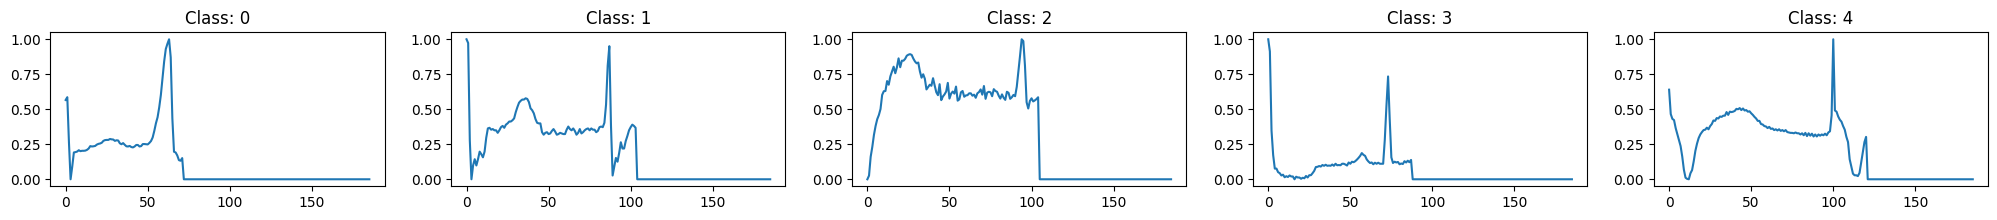

In [6]:
index = 0

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize=(25,2))

for i in range(5):
  ax[i].plot(train_df[train_df[187]==float(i)].sample(1).iloc[0,:186])
  ax[i].set_title('Class: '+str(i))



Text(0.5, 1.0, 'Class: 4')

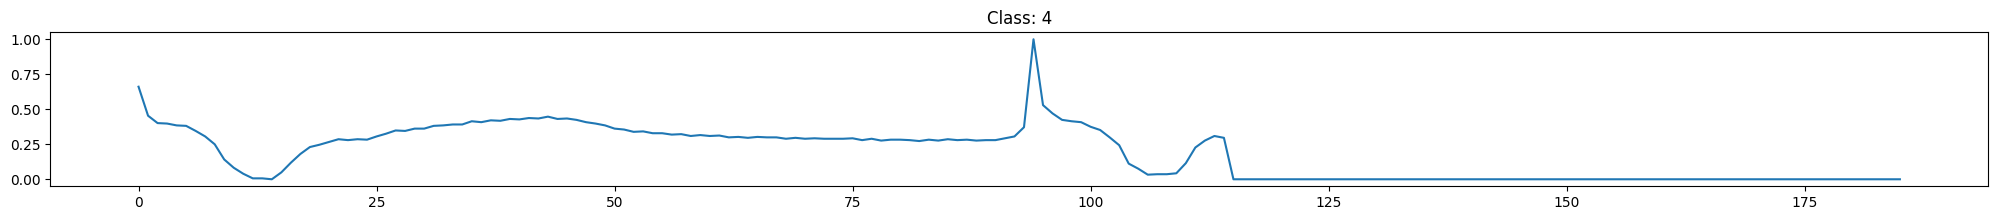

In [28]:
index = 0

fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize=(25,2))

ax.plot(train_df[train_df[187]==float(4)].sample(1).iloc[0,:186])
ax.set_title('Class: '+str(4))



**Data analysis**

In [6]:
train_df[187]=train_df[187].astype(int)
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    72471
4     6431
2     5788
1     2223
3      641
Name: count, dtype: int64


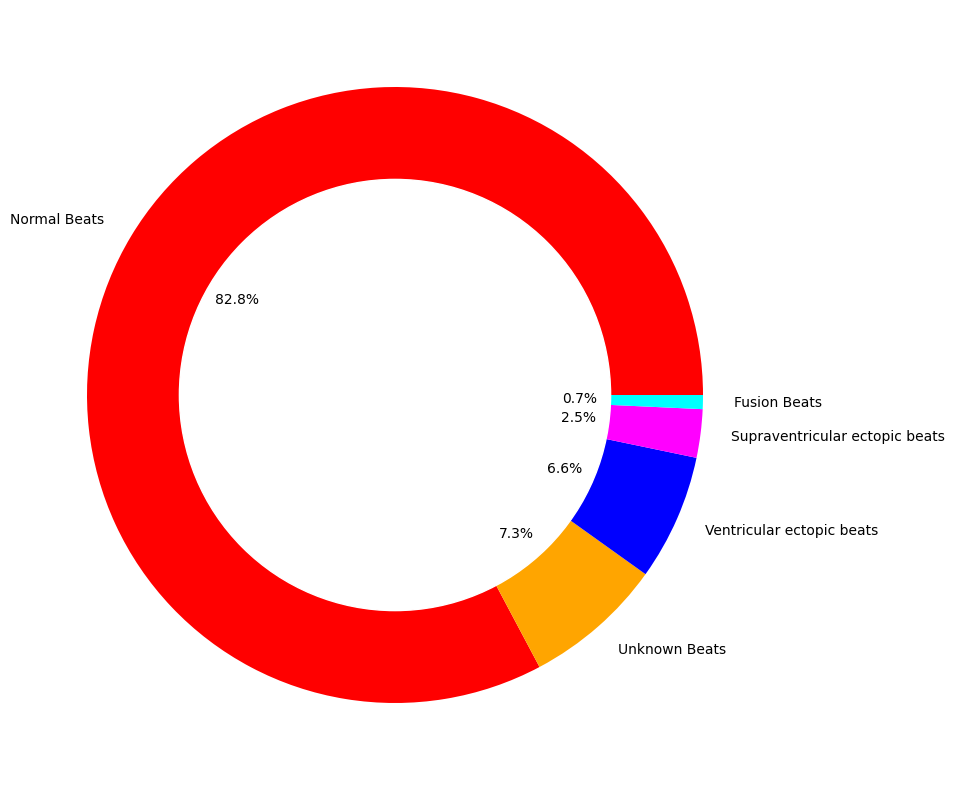

In [7]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal Beats','Unknown Beats','Ventricular ectopic beats',
                           'Supraventricular ectopic beats','Fusion Beats'], 
        colors=['red','orange','blue','magenta','cyan'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [8]:
from sklearn.utils import resample
df_1 = train_df[train_df[187] == 1]
df_2 = train_df[train_df[187] == 2]
df_3 = train_df[train_df[187] == 3]
df_4 = train_df[train_df[187] == 4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)

df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=20000,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=20000,random_state=126)

train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

In [9]:
equilibre=train_df[187].value_counts()
print(equilibre)

187
0    20000
1    20000
2    20000
3    20000
4    20000
Name: count, dtype: int64


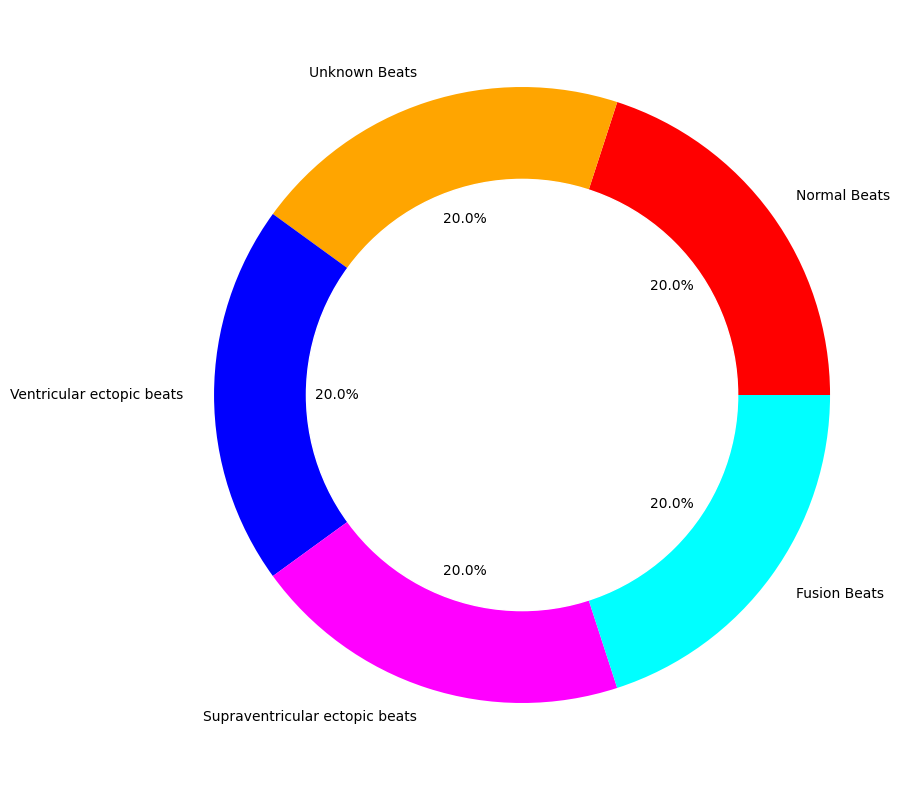

In [10]:
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(equilibre, labels=['Normal Beats','Unknown Beats','Ventricular ectopic beats',
                           'Supraventricular ectopic beats','Fusion Beats'], 
        colors=['red','orange','blue','magenta','cyan'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**clearing data (3-sigma)**

In [11]:
def detect_anomalies_3_sigma(data, sigma=3):
    mean = np.mean(data)
    std_deviation = np.std(data)
    
    lower_bound = mean - (sigma * std_deviation)
    upper_bound = mean + (sigma * std_deviation)

    anomalies = [(index, value) for index, value in enumerate(data) if value < lower_bound or value > upper_bound]
    return anomalies

anomaly_indexes_3_sigma = []


start = time.time()

for i in range(187):
    if not detect_anomalies_3_sigma(train_df[i]):
        anomaly_indexes_3_sigma.append(i)

finish = time.time()

print(anomaly_indexes_3_sigma)
print(len(anomaly_indexes_3_sigma))

[0, 1, 2, 3, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 87, 88, 89, 90, 97, 98, 99, 100, 101, 102, 103]
37


In [12]:
print(finish-start)

1.437248706817627


In [13]:
def remove_anomalies_3_sigma(data, sigma=3):
    mean = np.mean(data)
    std_deviation = np.std(data)
    
    lower_bound = mean - (sigma * std_deviation)
    upper_bound = mean + (sigma * std_deviation)
    cleaned_data = np.copy(data)
    for index, value in enumerate(data):
        if value < lower_bound or value > upper_bound:
            cleaned_data[index] = mean
    
    return cleaned_data

start = time.time()

train_df_cleaned_3_sigma =  train_df.copy()
for i in range(188):
    train_df_cleaned_3_sigma[i] = remove_anomalies_3_sigma(train_df[i])
finish = time.time()

In [14]:
print(finish-start)

1.5185396671295166


<Axes: >

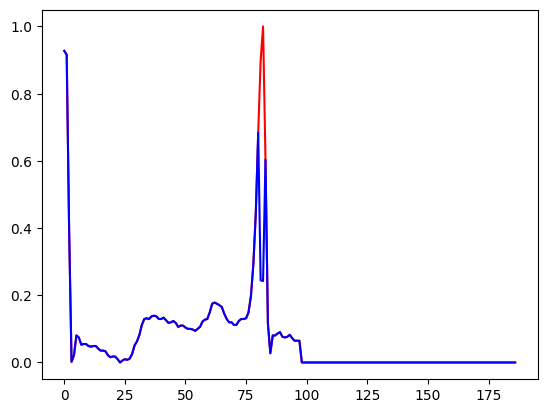

In [15]:
ax = train_df.iloc[7,:187].plot(color='red')
train_df_cleaned_3_sigma.iloc[7,:187].plot(ax=ax, color='blue')

**clearing data (IQR)**

In [16]:
def detect_anomalies_iqr(data, k=3):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    anomalies = [(index, value) for index, value in enumerate(data) if value < lower_bound or value > upper_bound]
    
    return anomalies

anomaly_indexes_iqr = []
start = time.time()
for i in range(187):
    anomaly_indexes_iqr.append(detect_anomalies_iqr(train_df[i]))
     
res = [value for value in anomaly_indexes_iqr if value]
print(*res)
print(len(res))
finish = time.time()

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [17]:
print(finish-start)

1.9450600147247314


<Axes: >

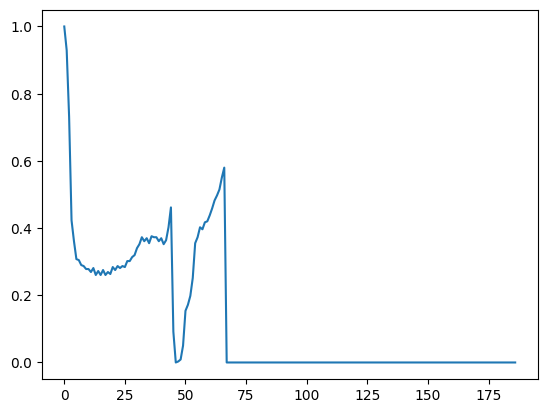

In [18]:
train_df.iloc[15,:187].plot()

In [19]:
def remove_anomalies_iqr(data, k=3):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - k * IQR
    upper_bound = Q3 + k * IQR
    
    mean = np.median(data)
    cleaned_data = np.copy(data)

    cleaned_data = np.where((data < lower_bound) | (data > upper_bound), mean, data)
    return cleaned_data

start = time.time()
train_df_cleaned_iqr =  train_df.copy()
for i in range(187):
    train_df_cleaned_iqr[i] = remove_anomalies_iqr(train_df[i])
finish = time.time()

In [20]:
print(finish-start)

0.45391178131103516


<Axes: >

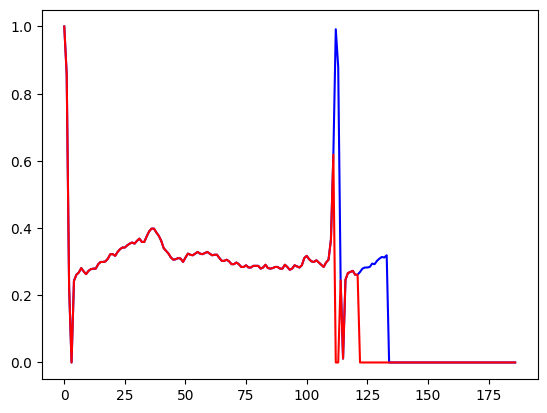

In [21]:
ax = train_df.iloc[231,:187].plot(color='blue')
train_df_cleaned_iqr.iloc[231,:187].plot(ax=ax,color='red')

**data clearing (wavelet)**

In [22]:
import numpy as np
import pywt


def detect_anomalies_wavelet(data, wavelet='db6', level=5, threshold=0.95):
    coeffs = pywt.wavedec(data, wavelet, mode='per', level=level)
    anomalies = []

    for i, coeff in enumerate(coeffs[-1]):
        if np.abs(coeff) > threshold:
            anomalies.append((i, coeff))
            coeffs[-1][i] = 0

    return anomalies


anomaly_indexes_wavelet = []
b = []
start = time.time()
for i in range(187):
    anomaly_indexes_wavelet.append(detect_anomalies_wavelet(train_df[i]))
    
for i in range(len(anomaly_indexes_wavelet)):
    if anomaly_indexes_wavelet[i] != []:
        b.append(i)
res = [value for value in anomaly_indexes_wavelet if value]
print(*res)
print(len(res))
print(b)
finish = time.time()


[(5174, -1.0247551873143552), (15703, -1.0233717327406149), (20260, -1.0291769038373177), (20280, -1.0313364945109127), (20284, -0.9770144960669204), (20412, 1.0629922378564207), (20526, -1.0455761303917879), (20532, -0.9572681080884627), (20801, -0.9591120245623423), (20855, -0.95710785900171), (20959, 0.9626746779921063), (21069, 0.9809147642223867), (21249, 0.9673134546416676), (21259, 1.073555253089248), (21329, 0.9591020928545009), (21344, -0.9584930612696675), (21579, -0.9602705447891856), (21780, -1.0575281206973317), (21816, 1.0132727315625984), (22103, 0.9861230885449155), (22195, -0.9767670103069045), (22226, 1.0052199330249265), (22244, 0.9598443209604178), (22276, 1.0039034482105826), (22279, 1.0087222133944758), (22286, 0.953792850027165), (22610, 0.9914315905268039), (22629, -1.0000859382293443), (22639, -1.0077215241139896), (22856, -1.0210210336221361), (23101, -1.0092897271696226), (23120, -1.0080561932808723), (23164, 1.005462380043159), (23278, 0.9752679608810413), (

In [23]:
print(finish-start)

4.369644641876221


<Axes: >

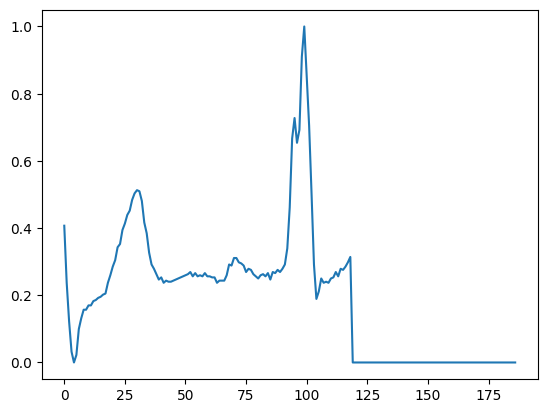

In [24]:
train_df.iloc[1222,:187].plot()

In [25]:
def wavelet_anomaly_detection(data, wavelet='db6', level=5, threshold=0.95):
    coeffs = pywt.wavedec(data, wavelet, mode='per', level=level)

    for i, coeff in enumerate(coeffs[-1]):
        if np.abs(coeff) > threshold:
            coeffs[-1][i] = 0
            
    return coeffs


def wavelet_anomaly_removal(data, coeffs, wavelet='db6'):
    cleaned_data = pywt.waverec(coeffs, wavelet, mode='per')
    cleaned_data = cleaned_data[:len(data)]
    return cleaned_data

train_df_cleaned_wavelet =  train_df.copy()
start = time.time()
for i in range(187):
    coeffs = wavelet_anomaly_detection(train_df[i])
    train_df_cleaned_wavelet[i] = wavelet_anomaly_removal(train_df[i], coeffs)
finish = time.time()

In [26]:
print(finish-start)

4.6947526931762695


<Axes: >

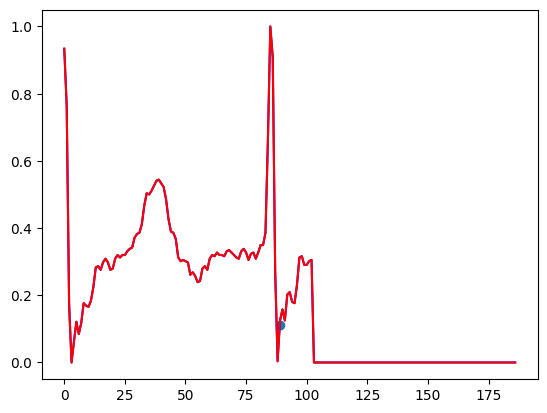

In [27]:
ax = train_df.iloc[866,:187].plot(color='blue')
plt.scatter(89, 0.111)
train_df_cleaned_wavelet.iloc[866,:187].plot(ax=ax,color='red')



**filtering(MAF)**

In [28]:
def moving_average_filter(data, window_size=3):
    return np.convolve(data, np.ones(window_size) / window_size, mode='same')

train_df_filtered_maf = train_df.copy()
start = time.time()
for i in range(len(train_df)):
    train_df_filtered_maf.iloc[i,:187] = moving_average_filter(train_df.iloc[i,:187])
finish = time.time()

In [29]:
print(finish-start)

1713.9883029460907


<Axes: >

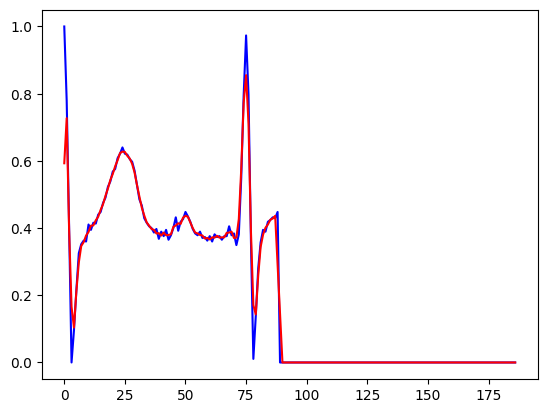

In [30]:
ax = train_df.iloc[2321,:187].plot(color='blue')
train_df_filtered_maf.iloc[2321,:187].plot(ax=ax,color='red')

**filtering(MF)**

In [31]:
import scipy.signal

def median_filter(data, window_size=3):
    return scipy.signal.medfilt(data, window_size)

train_df_filtered_mf = train_df.copy()
start = time.time()
for i in range(len(train_df)):
    train_df_filtered_mf.iloc[i,:187] = median_filter(train_df.iloc[i,:187])
finish = time.time()


In [32]:
print(finish-start)

1744.714420080185


<Axes: >

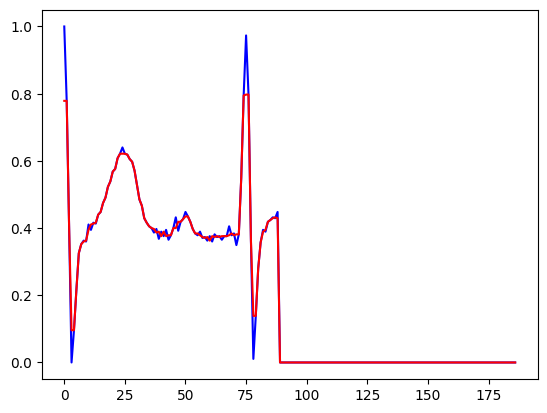

In [33]:
ax = train_df.iloc[2321,:187].plot(color='blue')
train_df_filtered_mf.iloc[2321,:187].plot(ax=ax,color='red')

**filtering(WD)**

In [34]:
def wavelet_denoise(data, wavelet='db6', level=5, threshold=0.5):
    coeffs = pywt.wavedec(data, wavelet, mode='per', level=level)
    threshold = threshold * np.max(coeffs[-1])
    coeffs[-1] = pywt.threshold(coeffs[-1], threshold)
    reconstructed = pywt.waverec(coeffs, wavelet, mode='per')
    

    if len(reconstructed) != len(data):
        reconstructed = np.resize(reconstructed, len(data))
    
    return reconstructed

train_df_filtered_wd = train_df.copy()
start = time.time()
for i in range(len(train_df)):
    train_df_filtered_wd.iloc[i,:187] = wavelet_denoise(train_df.iloc[i,:187])
finish = time.time()

In [35]:
print(finish-start)

1718.8248007297516


<Axes: >

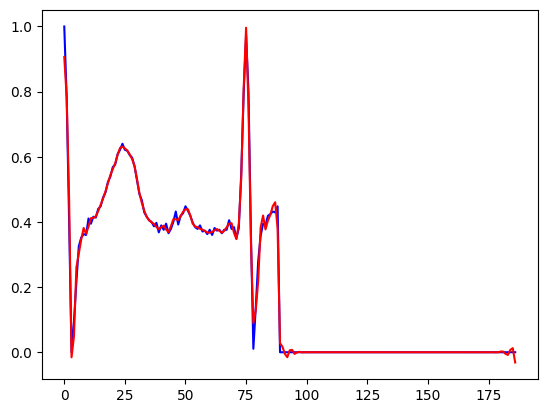

In [36]:
ax = train_df.iloc[2321,:187].plot(color='blue')
train_df_filtered_wd.iloc[2321,:187].plot(ax=ax,color='red')

**normalizing data** 

without clearing

In [37]:
x_train = train_df.drop(columns = [187])
y_train = train_df[187]

In [38]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_test = test_df.drop(columns=[187])
y_test = test_df[187]

scaler = StandardScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_valid_normalized = scaler.transform(x_valid)
x_test_normalized = scaler.transform(x_test)

3_sigma

In [39]:
x_train_3_sigma = train_df_cleaned_3_sigma.drop(columns = [187])
y_train_3_sigma = train_df_cleaned_3_sigma[187]

In [40]:
x_train_3_sigma, x_valid_3_sigma, y_train_3_sigma, y_valid_3_sigma = train_test_split(x_train_3_sigma, y_train_3_sigma, test_size=0.2, random_state=42)

x_test_3_sigma = test_df.drop(columns=[187])
y_test_3_sigma = test_df[187]

scaler = StandardScaler()

x_train_normalized_3_sigma = scaler.fit_transform(x_train_3_sigma)
x_valid_normalized_3_sigma = scaler.transform(x_valid_3_sigma)
x_test_normalized_3_sigma = scaler.transform(x_test_3_sigma)

IQR

In [41]:
x_train_iqr = train_df_cleaned_iqr.drop(columns = [187])
y_train_iqr = train_df_cleaned_iqr[187]

In [42]:
x_train_iqr, x_valid_iqr, y_train_iqr, y_valid_iqr = train_test_split(x_train_iqr, y_train_iqr, test_size=0.2, random_state=42)

x_test_iqr = test_df.drop(columns=[187])
y_test_iqr = test_df[187]

scaler = StandardScaler()

x_train_normalized_iqr = scaler.fit_transform(x_train_iqr)
x_valid_normalized_iqr = scaler.transform(x_valid_iqr)
x_test_normalized_iqr = scaler.transform(x_test_iqr)

wavelet

In [43]:
x_train_wavelet = train_df_cleaned_wavelet.drop(columns = [187])
y_train_wavelet = train_df_cleaned_wavelet[187]

In [44]:
x_train_wavelet, x_valid_wavelet, y_train_wavelet, y_valid_wavelet = train_test_split(x_train_wavelet, y_train_wavelet, test_size=0.2, random_state=42)

x_test_wavelet = test_df.drop(columns=[187])
y_test_wavelet = test_df[187]

scaler = StandardScaler()

x_train_normalized_wavelet = scaler.fit_transform(x_train_wavelet)
x_valid_normalized_wavelet = scaler.transform(x_valid_wavelet)
x_test_normalized_wavelet = scaler.transform(x_test_wavelet)

MAF

In [45]:
x_train_maf = train_df_filtered_maf.drop(columns = [187])
y_train_maf = train_df_filtered_maf[187]

In [46]:
x_train_maf, x_valid_maf, y_train_maf, y_valid_maf = train_test_split(x_train_maf, y_train_maf, test_size=0.2, random_state=42)

x_test_maf = test_df.drop(columns=[187])
y_test_maf = test_df[187]

scaler = StandardScaler()

x_train_normalized_maf = scaler.fit_transform(x_train_maf)
x_valid_normalized_maf = scaler.transform(x_valid_maf)
x_test_normalized_maf = scaler.transform(x_test_maf)

MF

In [47]:
x_train_mf = train_df_filtered_mf.drop(columns = [187])
y_train_mf = train_df_filtered_mf[187]

In [48]:
x_train_mf, x_valid_mf, y_train_mf, y_valid_mf = train_test_split(x_train_mf, y_train_mf, test_size=0.2, random_state=42)

x_test_mf = test_df.drop(columns=[187])
y_test_mf = test_df[187]

scaler = StandardScaler()

x_train_normalized_mf = scaler.fit_transform(x_train_mf)
x_valid_normalized_mf = scaler.transform(x_valid_mf)
x_test_normalized_mf = scaler.transform(x_test_mf)

WD

In [49]:
x_train_wd = train_df_filtered_wd.drop(columns = [187])
y_train_wd = train_df_filtered_wd[187]

In [50]:
x_train_wd, x_valid_wd, y_train_wd, y_valid_wd = train_test_split(x_train_wd, y_train_wd, test_size=0.2, random_state=42)

x_test_wd = test_df.drop(columns=[187])
y_test_wd = test_df[187]

scaler = StandardScaler()

x_train_normalized_wd = scaler.fit_transform(x_train_wd)
x_valid_normalized_wd = scaler.transform(x_valid_wd)
x_test_normalized_wd = scaler.transform(x_test_wd)

**Classification**

In [51]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized, y_train)

start = time.time()
y_pred_valid = svm_classifier.predict(x_valid_normalized)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

start = time.time()
y_pred_test = svm_classifier.predict(x_test_normalized)
finish = time.time()
y_score = svm_classifier.predict_proba(x_test_normalized)

print("Test predict time:", finish - start)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)


print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))


Validation predict time: 51.018842697143555
Validation Accuracy: 0.9443
Test predict time: 58.72821640968323
Test Accuracy: 0.9078202082952677

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95     18118
         1.0       0.36      0.82      0.50       556
         2.0       0.85      0.92      0.88      1448
         3.0       0.17      0.93      0.29       162
         4.0       0.95      0.97      0.96      1608

    accuracy                           0.91     21892
   macro avg       0.66      0.91      0.72     21892
weighted avg       0.96      0.91      0.93     21892



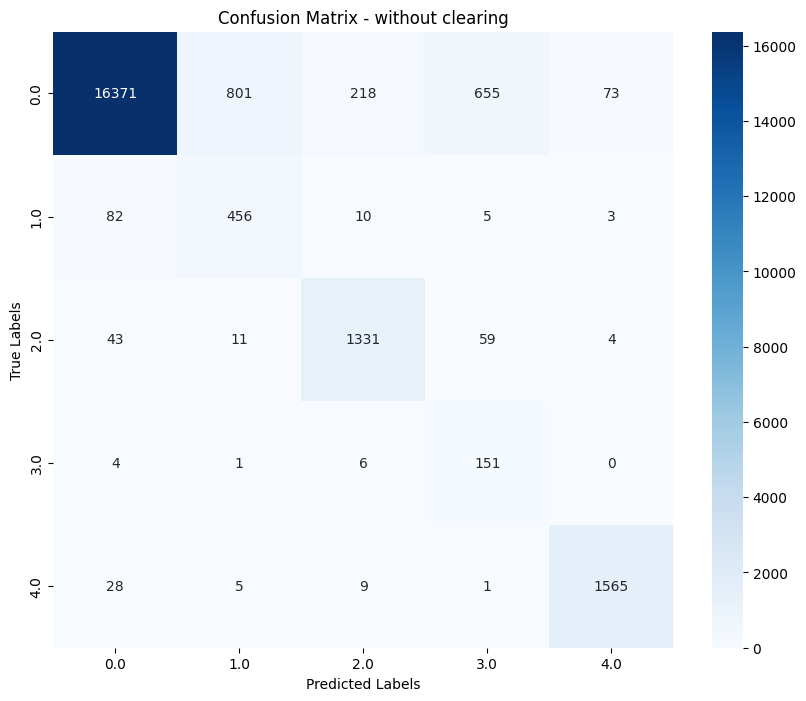

In [52]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [53]:
y_test = y_test.values
from sklearn.preprocessing import label_binarize
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])


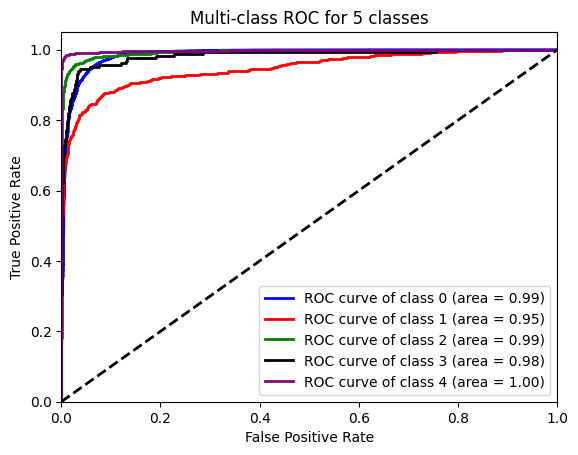

In [54]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

3 sigma


In [55]:
svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized_3_sigma, y_train_3_sigma)

start = time.time()
y_pred_valid_3_sigma = svm_classifier.predict(x_valid_normalized_3_sigma)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_3_sigma = accuracy_score(y_valid_3_sigma, y_pred_valid_3_sigma)
print("Validation Accuracy:", accuracy_valid_3_sigma)

start = time.time()
y_pred_test_3_sigma = svm_classifier.predict(x_test_normalized_3_sigma)
finish = time.time()
y_score_3_sigma = svm_classifier.predict_proba(x_test_normalized_3_sigma)


print("Test predict time:", finish - start)
accuracy_test_3_sigma = accuracy_score(y_test_3_sigma, y_pred_test_3_sigma)
print("Test Accuracy:", accuracy_test_3_sigma)

print("\nClassification Report:")
print(classification_report(y_test_3_sigma, y_pred_test_3_sigma))


Validation predict time: 55.85722756385803
Validation Accuracy: 0.942
Test predict time: 60.98608422279358
Test Accuracy: 0.8477982824776173

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.85      0.91     18118
         1.0       0.27      0.68      0.38       556
         2.0       0.60      0.80      0.68      1448
         3.0       0.13      0.93      0.23       162
         4.0       0.94      0.97      0.96      1608

    accuracy                           0.85     21892
   macro avg       0.58      0.84      0.63     21892
weighted avg       0.92      0.85      0.88     21892



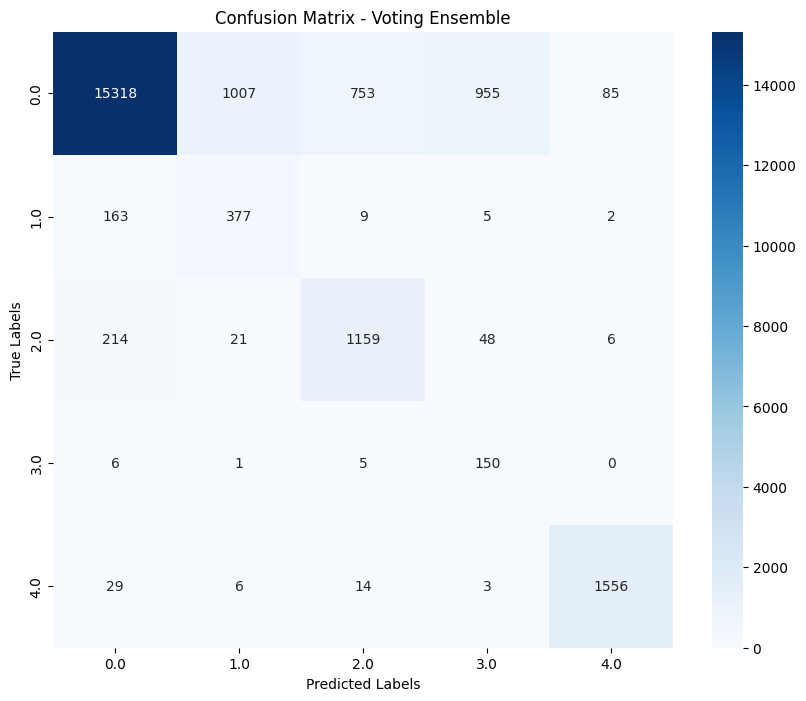

In [56]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test_3_sigma)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_3_sigma, y_pred_test_3_sigma)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Voting Ensemble')
plt.show()

In [57]:
y_test_3_sigma = y_test_3_sigma.values
from sklearn.preprocessing import label_binarize
y_test_3_sigma = label_binarize(y_test_3_sigma, classes=[0, 1, 2, 3, 4])

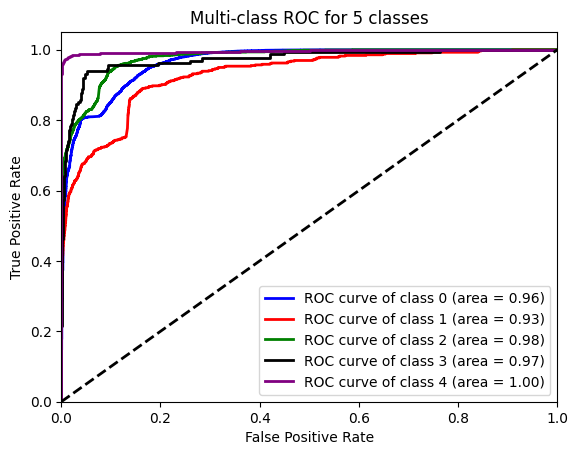

In [58]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_3_sigma])
    fpr[i], tpr[i], _ = roc_curve(y_test_3_sigma[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

iqr

In [59]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized_iqr, y_train_iqr)

start = time.time()
y_pred_valid_iqr = svm_classifier.predict(x_valid_normalized_iqr)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_iqr = accuracy_score(y_valid_iqr, y_pred_valid_iqr)
print("Validation Accuracy:", accuracy_valid_iqr)

start = time.time()
y_pred_test_iqr = svm_classifier.predict(x_test_normalized_iqr)
finish = time.time()
y_score_iqr = svm_classifier.predict_proba(x_test_normalized_iqr)

print("Test predict time:", finish - start)
accuracy_test_iqr = accuracy_score(y_test_iqr, y_pred_test_iqr)
print("Test Accuracy:", accuracy_test_iqr)

print("\nClassification Report:")
print(classification_report(y_test_iqr, y_pred_test_iqr))


Validation predict time: 49.63066554069519
Validation Accuracy: 0.9552
Test predict time: 53.40438771247864
Test Accuracy: 0.888863511785127

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.92      0.94     18118
         1.0       0.33      0.61      0.43       556
         2.0       0.80      0.66      0.73      1448
         3.0       0.21      0.94      0.34       162
         4.0       0.94      0.84      0.89      1608

    accuracy                           0.89     21892
   macro avg       0.65      0.79      0.66     21892
weighted avg       0.92      0.89      0.90     21892



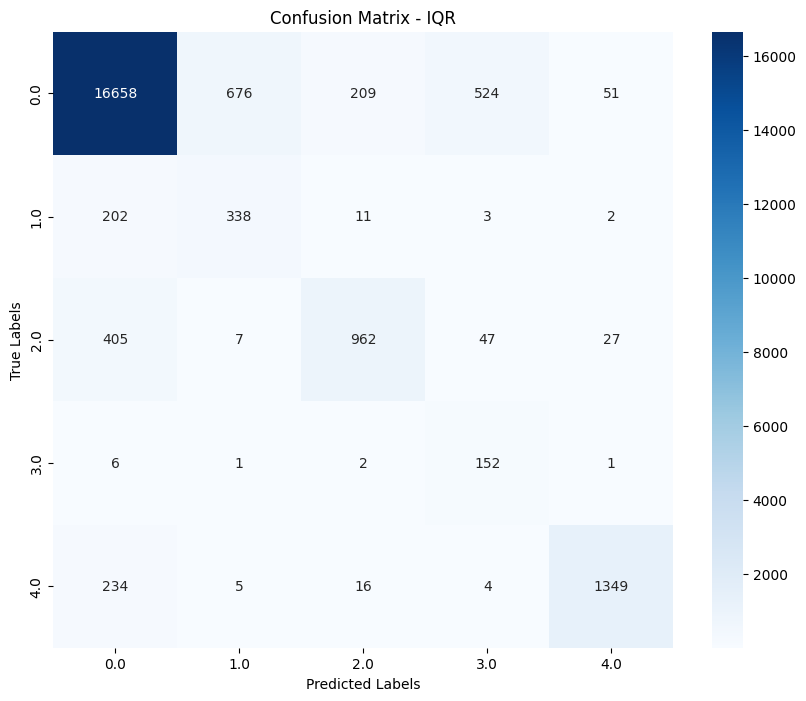

In [60]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test_iqr)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_iqr, y_pred_test_iqr)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - IQR')
plt.show()

In [61]:
y_test_iqr = y_test_iqr.values
from sklearn.preprocessing import label_binarize
y_test_iqr = label_binarize(y_test_iqr, classes=[0, 1, 2, 3, 4])

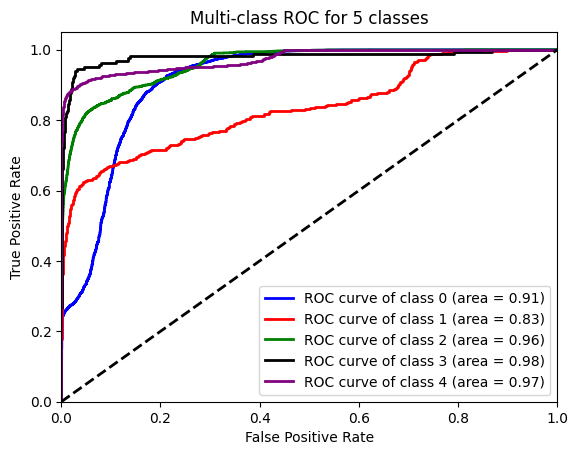

In [62]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_iqr])
    fpr[i], tpr[i], _ = roc_curve(y_test_iqr[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

wavelet


In [63]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized_wavelet, y_train_wavelet)

start = time.time()
y_pred_valid_wavelet = svm_classifier.predict(x_valid_normalized_wavelet)
finish = time.time()


print("Validation predict time:", finish - start)
accuracy_valid_wavelet = accuracy_score(y_valid_wavelet, y_pred_valid_wavelet)
print("Validation Accuracy:", accuracy_valid_wavelet)

start = time.time()
y_pred_test_wavelet = svm_classifier.predict(x_test_normalized_wavelet)
finish = time.time()
y_score_wavelet = svm_classifier.predict_proba(x_test_normalized_wavelet)

print("Test predict time:", finish - start)
accuracy_test_wavelet = accuracy_score(y_test_wavelet, y_pred_test_wavelet)
print("Test Accuracy:", accuracy_test_wavelet)

print("\nClassification Report:")
print(classification_report(y_test_wavelet, y_pred_test_wavelet))

Validation predict time: 49.326985120773315
Validation Accuracy: 0.94415
Test predict time: 55.54475021362305
Test Accuracy: 0.9077288507217248

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.90      0.95     18118
         1.0       0.36      0.82      0.50       556
         2.0       0.85      0.92      0.88      1448
         3.0       0.17      0.93      0.29       162
         4.0       0.95      0.97      0.96      1608

    accuracy                           0.91     21892
   macro avg       0.66      0.91      0.72     21892
weighted avg       0.96      0.91      0.93     21892



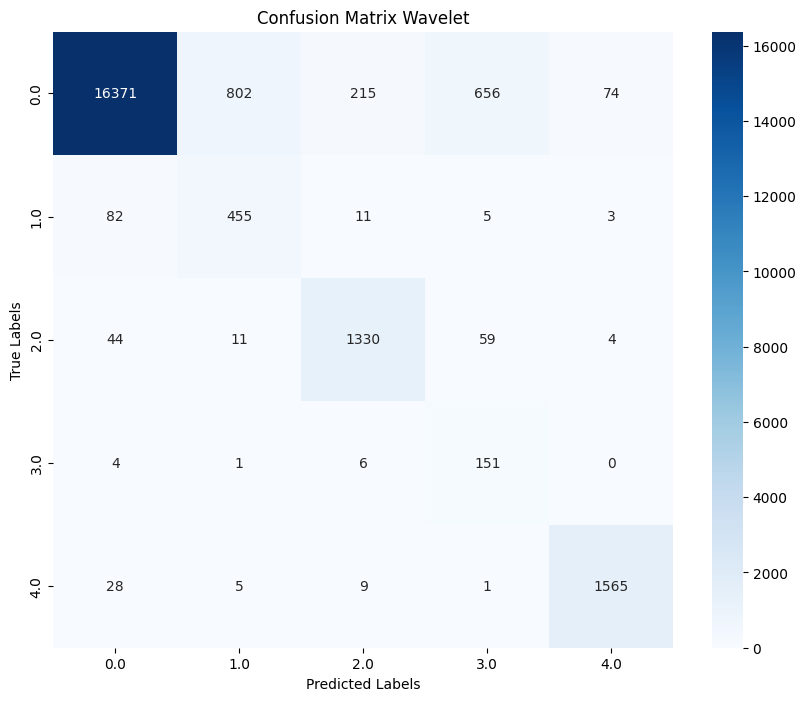

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test_wavelet)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_wavelet, y_pred_test_wavelet)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix Wavelet')
plt.show()

In [65]:

from sklearn.preprocessing import label_binarize
y_test_wavelet = label_binarize(y_test_wavelet, classes=[0, 1, 2, 3, 4])

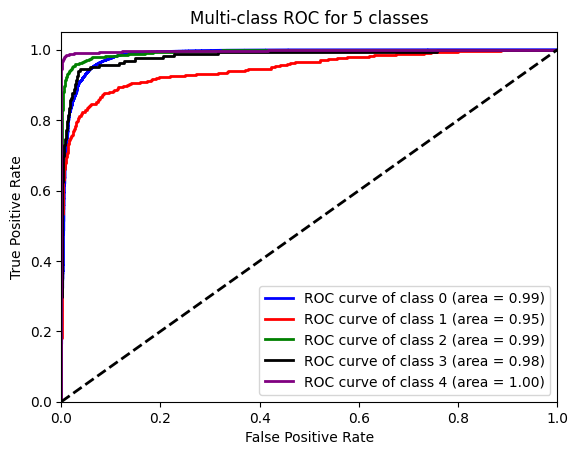

In [66]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_wavelet])
    fpr[i], tpr[i], _ = roc_curve(y_test_wavelet[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

MAF

In [67]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized_maf, y_train_maf)

start = time.time()
y_pred_valid_maf = svm_classifier.predict(x_valid_normalized_maf)
finish = time.time()


print("Validation predict time:", finish - start)
accuracy_valid_maf = accuracy_score(y_valid_maf, y_pred_valid_maf)
print("Validation Accuracy:", accuracy_valid_maf)

start = time.time()
y_pred_test_maf = svm_classifier.predict(x_test_normalized_maf)
finish = time.time()
y_score_maf = svm_classifier.predict_proba(x_test_normalized_maf)

print("Test predict time:", finish - start)
accuracy_test_maf = accuracy_score(y_test_maf, y_pred_test_maf)
print("Test Accuracy:", accuracy_test_maf)

print("\nClassification Report:")
print(classification_report(y_test_maf, y_pred_test_maf))

Validation predict time: 52.10989212989807
Validation Accuracy: 0.93775
Test predict time: 57.62011647224426
Test Accuracy: 0.9151744929654668

Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     18118
         1.0       0.35      0.78      0.48       556
         2.0       0.93      0.82      0.87      1448
         3.0       0.51      0.67      0.58       162
         4.0       0.99      0.68      0.81      1608

    accuracy                           0.92     21892
   macro avg       0.75      0.78      0.74     21892
weighted avg       0.94      0.92      0.92     21892



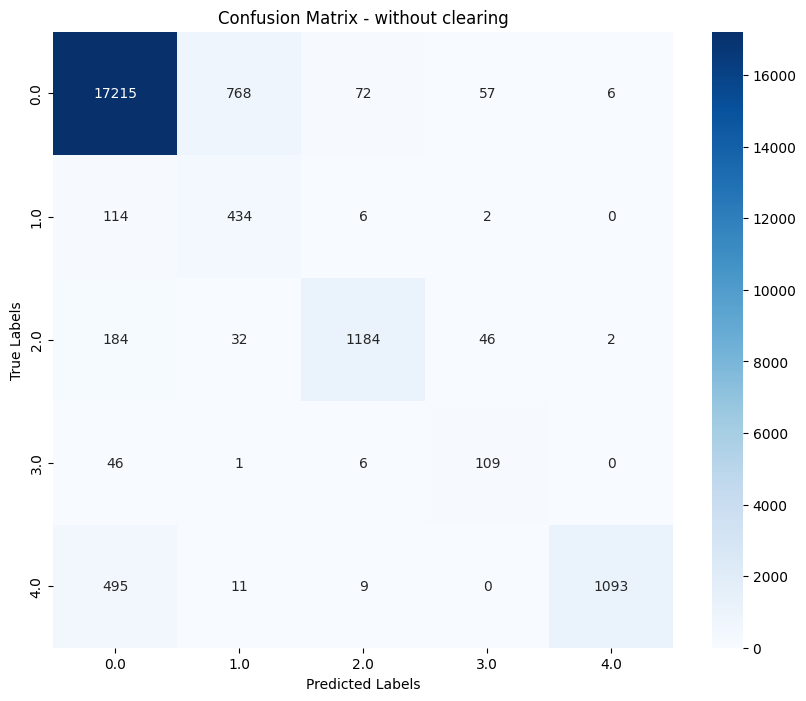

In [68]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Extract unique labels from the target variable
labels = np.unique(y_test_maf)
# Calculate confusion matrix for the test set
conf_matrix = confusion_matrix(y_test_maf, y_pred_test_maf)

# Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [69]:
from sklearn.preprocessing import label_binarize
y_test_maf = label_binarize(y_test_maf, classes=[0, 1, 2, 3, 4])

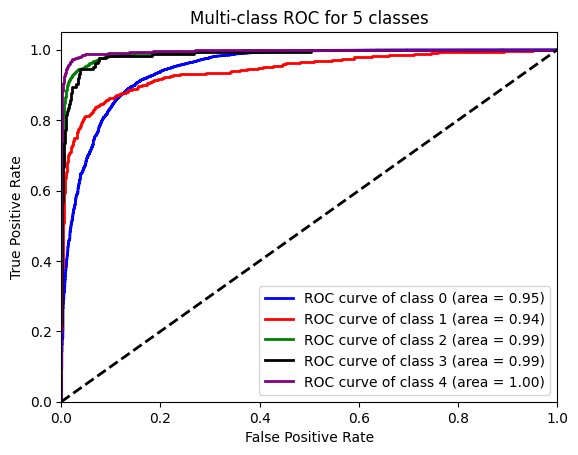

In [70]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_maf])
    fpr[i], tpr[i], _ = roc_curve(y_test_maf[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

mf

In [71]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized_mf, y_train_mf)

start = time.time()
y_pred_valid_mf = svm_classifier.predict(x_valid_normalized_mf)
finish = time.time()


print("Validation predict time:", finish - start)
accuracy_valid_mf = accuracy_score(y_valid_mf, y_pred_valid_mf)
print("Validation Accuracy:", accuracy_valid_mf)
y_score_mf = svm_classifier.predict_proba(x_test_normalized_mf)

start = time.time()
y_pred_test_mf = svm_classifier.predict(x_test_normalized_mf)
finish = time.time()

print("Test predict time:", finish - start)
accuracy_test_mf = accuracy_score(y_test_mf, y_pred_test_mf)
print("Test Accuracy:", accuracy_test_mf)



print("\nClassification Report:")
print(classification_report(y_test_mf, y_pred_test_mf))

Validation predict time: 53.996848583221436
Validation Accuracy: 0.941
Test predict time: 56.50324487686157
Test Accuracy: 0.9099214324867532

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.91      0.95     18118
         1.0       0.34      0.81      0.48       556
         2.0       0.85      0.92      0.88      1448
         3.0       0.18      0.93      0.31       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.91     21892
   macro avg       0.67      0.90      0.72     21892
weighted avg       0.96      0.91      0.93     21892



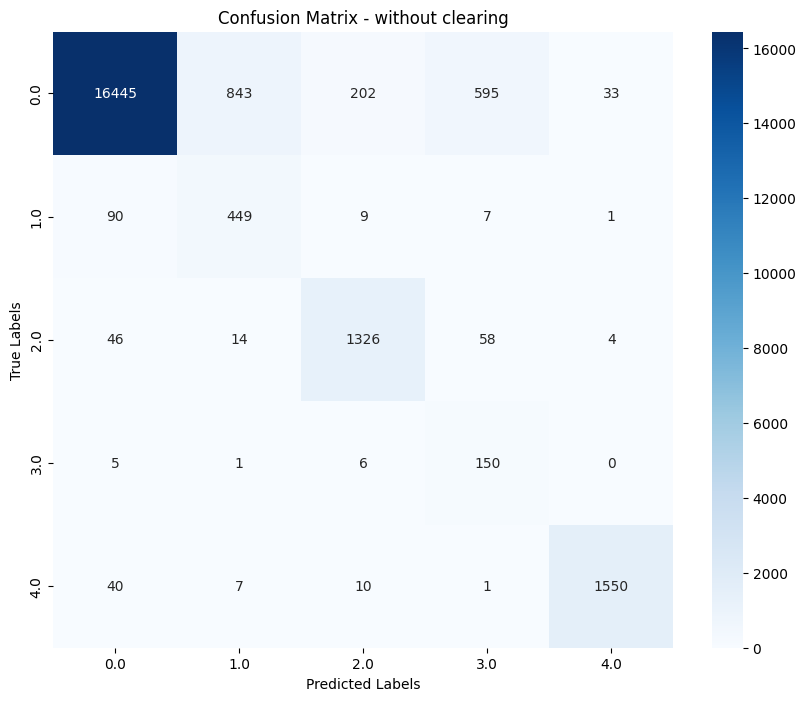

In [72]:
labels = np.unique(y_test_mf)

conf_matrix = confusion_matrix(y_test_mf, y_pred_test_mf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [73]:
from sklearn.preprocessing import label_binarize
y_test_mf = label_binarize(y_test_mf, classes=[0, 1, 2, 3, 4])

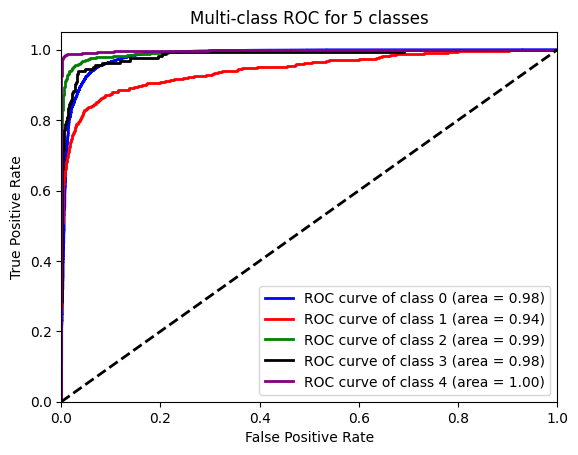

In [74]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_mf])
    fpr[i], tpr[i], _ = roc_curve(y_test_mf[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

WD

In [75]:
from sklearn import svm
from sklearn.metrics import accuracy_score

svm_classifier = svm.SVC(kernel='rbf', random_state=42, probability=True)


svm_classifier.fit(x_train_normalized_wd, y_train_wd)

start = time.time()
y_pred_valid_wd = svm_classifier.predict(x_valid_normalized_wd)
finish = time.time()


print("Validation predict time:", finish - start)
accuracy_valid_wd = accuracy_score(y_valid_wd, y_pred_valid_wd)
print("Validation Accuracy:", accuracy_valid_wd)
y_score_wd = svm_classifier.predict_proba(x_test_normalized_wd)

start = time.time()
y_pred_test_wd = svm_classifier.predict(x_test_normalized_wd)
finish = time.time()

print("Test predict time:", finish - start)
accuracy_test_wd = accuracy_score(y_test_wd, y_pred_test_wd)
print("Test Accuracy:", accuracy_test_wd)



print("\nClassification Report:")
print(classification_report(y_test_wd, y_pred_test_wd))

Validation predict time: 51.64997148513794
Validation Accuracy: 0.94275
Test predict time: 56.10875630378723
Test Accuracy: 0.9174127535172666

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.92      0.95     18118
         1.0       0.35      0.80      0.49       556
         2.0       0.87      0.92      0.90      1448
         3.0       0.20      0.91      0.33       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.92     21892
   macro avg       0.68      0.90      0.73     21892
weighted avg       0.96      0.92      0.93     21892



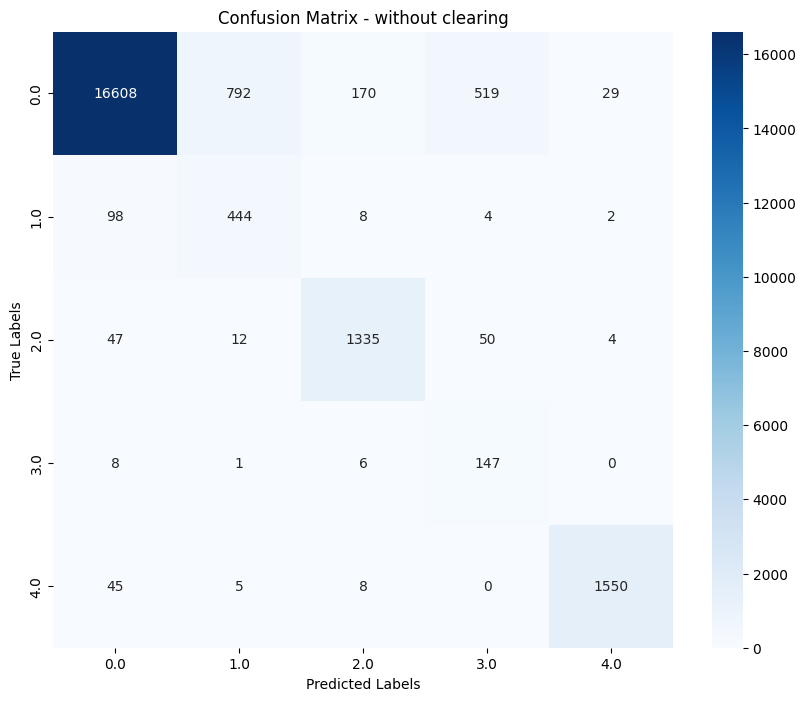

In [76]:
labels = np.unique(y_test_wd)

conf_matrix = confusion_matrix(y_test_wd, y_pred_test_wd)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [77]:
from sklearn.preprocessing import label_binarize
y_test_wd = label_binarize(y_test_wd, classes=[0, 1, 2, 3, 4])

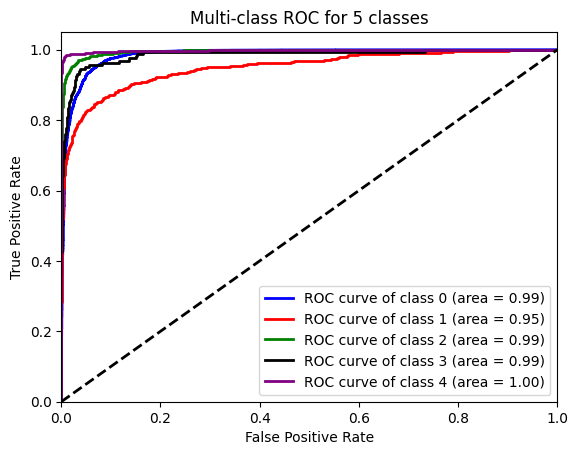

In [78]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_wd])
    fpr[i], tpr[i], _ = roc_curve(y_test_wd[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

**RFT**

without clearing

In [83]:
x_train = train_df.drop(columns = [187])
y_train = train_df[187]

In [84]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_test = test_df.drop(columns=[187])
y_test = test_df[187]

scaler = StandardScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_valid_normalized = scaler.transform(x_valid)
x_test_normalized = scaler.transform(x_test)

3_sigma

In [85]:
x_train_3_sigma = train_df_cleaned_3_sigma.drop(columns = [187])
y_train_3_sigma = train_df_cleaned_3_sigma[187]

In [86]:
x_train_3_sigma, x_valid_3_sigma, y_train_3_sigma, y_valid_3_sigma = train_test_split(x_train_3_sigma, y_train_3_sigma, test_size=0.2, random_state=42)

x_test_3_sigma = test_df.drop(columns=[187])
y_test_3_sigma = test_df[187]

scaler = StandardScaler()

x_train_normalized_3_sigma = scaler.fit_transform(x_train_3_sigma)
x_valid_normalized_3_sigma = scaler.transform(x_valid_3_sigma)
x_test_normalized_3_sigma = scaler.transform(x_test_3_sigma)

IQR

In [87]:
x_train_iqr = train_df_cleaned_iqr.drop(columns = [187])
y_train_iqr = train_df_cleaned_iqr[187]

In [88]:
x_train_iqr, x_valid_iqr, y_train_iqr, y_valid_iqr = train_test_split(x_train_iqr, y_train_iqr, test_size=0.2, random_state=42)

x_test_iqr = test_df.drop(columns=[187])
y_test_iqr = test_df[187]

scaler = StandardScaler()

x_train_normalized_iqr = scaler.fit_transform(x_train_iqr)
x_valid_normalized_iqr = scaler.transform(x_valid_iqr)
x_test_normalized_iqr = scaler.transform(x_test_iqr)

wavelet

In [89]:
x_train_wavelet = train_df_cleaned_wavelet.drop(columns = [187])
y_train_wavelet = train_df_cleaned_wavelet[187]

In [90]:
x_train_wavelet, x_valid_wavelet, y_train_wavelet, y_valid_wavelet = train_test_split(x_train_wavelet, y_train_wavelet, test_size=0.2, random_state=42)

x_test_wavelet = test_df.drop(columns=[187])
y_test_wavelet = test_df[187]

scaler = StandardScaler()

x_train_normalized_wavelet = scaler.fit_transform(x_train_wavelet)
x_valid_normalized_wavelet = scaler.transform(x_valid_wavelet)
x_test_normalized_wavelet = scaler.transform(x_test_wavelet)

MAF

In [91]:
x_train_maf = train_df_filtered_maf.drop(columns = [187])
y_train_maf = train_df_filtered_maf[187]

In [92]:
x_train_maf, x_valid_maf, y_train_maf, y_valid_maf = train_test_split(x_train_maf, y_train_maf, test_size=0.2, random_state=42)

x_test_maf = test_df.drop(columns=[187])
y_test_maf = test_df[187]

scaler = StandardScaler()

x_train_normalized_maf = scaler.fit_transform(x_train_maf)
x_valid_normalized_maf = scaler.transform(x_valid_maf)
x_test_normalized_maf = scaler.transform(x_test_maf)

MF

In [93]:
x_train_mf = train_df_filtered_mf.drop(columns = [187])
y_train_mf = train_df_filtered_mf[187]

In [94]:
x_train_mf, x_valid_mf, y_train_mf, y_valid_mf = train_test_split(x_train_mf, y_train_mf, test_size=0.2, random_state=42)

x_test_mf = test_df.drop(columns=[187])
y_test_mf = test_df[187]

scaler = StandardScaler()

x_train_normalized_mf = scaler.fit_transform(x_train_mf)
x_valid_normalized_mf = scaler.transform(x_valid_mf)
x_test_normalized_mf = scaler.transform(x_test_mf)

WD

In [95]:
x_train_wd = train_df_filtered_wd.drop(columns = [187])
y_train_wd = train_df_filtered_wd[187]

In [96]:
x_train_wd, x_valid_wd, y_train_wd, y_valid_wd = train_test_split(x_train_wd, y_train_wd, test_size=0.2, random_state=42)

x_test_wd = test_df.drop(columns=[187])
y_test_wd = test_df[187]

scaler = StandardScaler()

x_train_normalized_wd = scaler.fit_transform(x_train_wd)
x_valid_normalized_wd = scaler.transform(x_valid_wd)
x_test_normalized_wd = scaler.transform(x_test_wd)

without clearing

In [97]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized, y_train)

start = time.time()
y_pred_valid = rf_classifier.predict(x_valid_normalized)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)

start = time.time()
y_pred_test = rf_classifier.predict(x_test_normalized)
finish = time.time()
y_score = rf_classifier.predict_proba(x_test_normalized)

print("Test predict time:", finish - start)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)


print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Validation predict time: 0.11162829399108887
Validation Accuracy: 0.99585
Test predict time: 0.10863780975341797
Test Accuracy: 0.97496802484926

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.80      0.75      0.78       556
         2.0       0.93      0.94      0.93      1448
         3.0       0.76      0.74      0.75       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.89      0.88      0.88     21892
weighted avg       0.97      0.97      0.97     21892



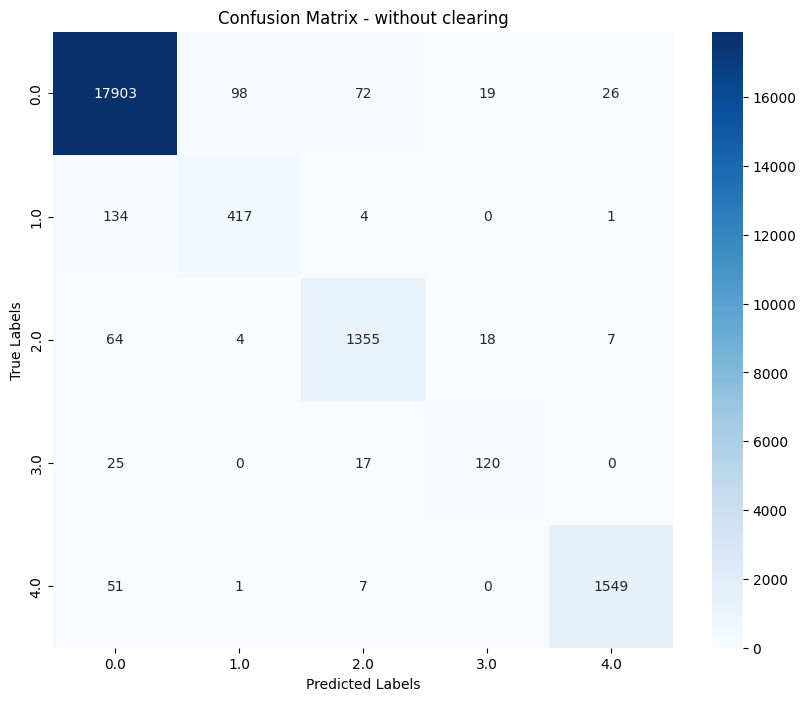

In [98]:
labels = np.unique(y_test)

conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [99]:
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

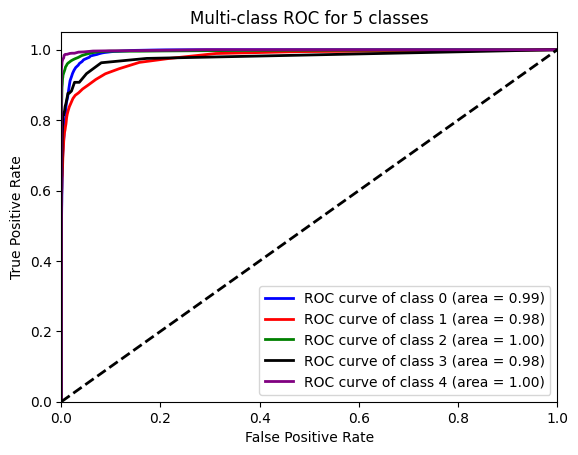

In [100]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

3-sigma

In [101]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized_3_sigma, y_train_3_sigma)

start = time.time()
y_pred_valid_3_sigma = rf_classifier.predict(x_valid_normalized_3_sigma)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_3_sigma = accuracy_score(y_valid_3_sigma, y_pred_valid_3_sigma)
print("Validation Accuracy:", accuracy_valid_3_sigma)

start = time.time()
y_pred_test_3_sigma = rf_classifier.predict(x_test_normalized_3_sigma)
finish = time.time()
y_score_3_sigma = rf_classifier.predict_proba(x_test_normalized_3_sigma)

print("Test predict time:", finish - start)
accuracy_test_3_sigma = accuracy_score(y_test_3_sigma, y_pred_test_3_sigma)
print("Test Accuracy:", accuracy_test_3_sigma)


print("\nClassification Report:")
print(classification_report(y_test_3_sigma, y_pred_test_3_sigma))

Validation predict time: 0.10764145851135254
Validation Accuracy: 0.99565
Test predict time: 0.11362123489379883
Test Accuracy: 0.9730951945916316

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.79      0.69      0.74       556
         2.0       0.93      0.94      0.93      1448
         3.0       0.76      0.70      0.73       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.89      0.86      0.87     21892
weighted avg       0.97      0.97      0.97     21892



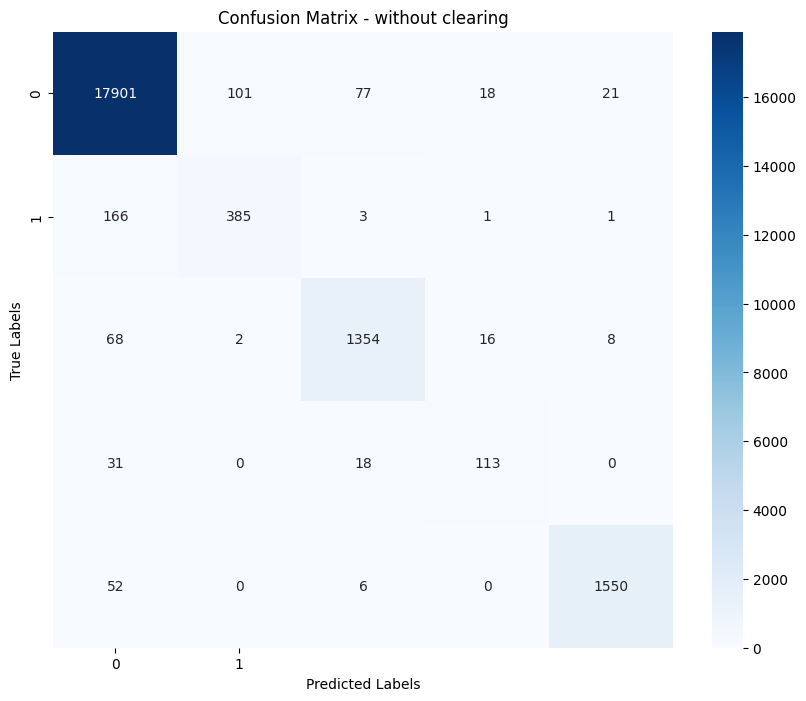

In [102]:
labels = np.unique(y_test)

conf_matrix = confusion_matrix(y_test_3_sigma, y_pred_test_3_sigma)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [103]:
y_test_3_sigma = label_binarize(y_test_3_sigma, classes=[0, 1, 2, 3, 4])

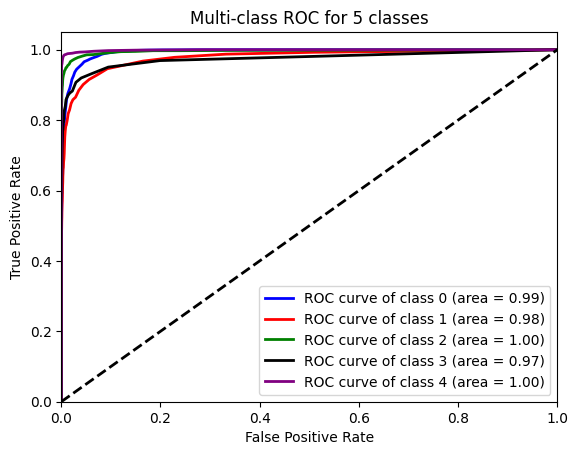

In [104]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_3_sigma])
    fpr[i], tpr[i], _ = roc_curve(y_test_3_sigma[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

IQR

In [105]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized_iqr, y_train_iqr)

start = time.time()
y_pred_valid_iqr = rf_classifier.predict(x_valid_normalized_iqr)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_iqr = accuracy_score(y_valid_iqr, y_pred_valid_iqr)
print("Validation Accuracy:", accuracy_valid_iqr)

start = time.time()
y_pred_test_iqr = rf_classifier.predict(x_test_normalized_iqr)
finish = time.time()
y_score_iqr = rf_classifier.predict_proba(x_test_normalized_iqr)

print("Test predict time:", finish - start)
accuracy_test_iqr = accuracy_score(y_test_iqr, y_pred_test_iqr)
print("Test Accuracy:", accuracy_test_iqr)


print("\nClassification Report:")
print(classification_report(y_test_iqr, y_pred_test_iqr))

Validation predict time: 0.10966873168945312
Validation Accuracy: 0.99605
Test predict time: 0.10864114761352539
Test Accuracy: 0.9745569157683172

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.83      0.73      0.78       556
         2.0       0.93      0.93      0.93      1448
         3.0       0.78      0.74      0.76       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.90      0.87      0.88     21892
weighted avg       0.97      0.97      0.97     21892



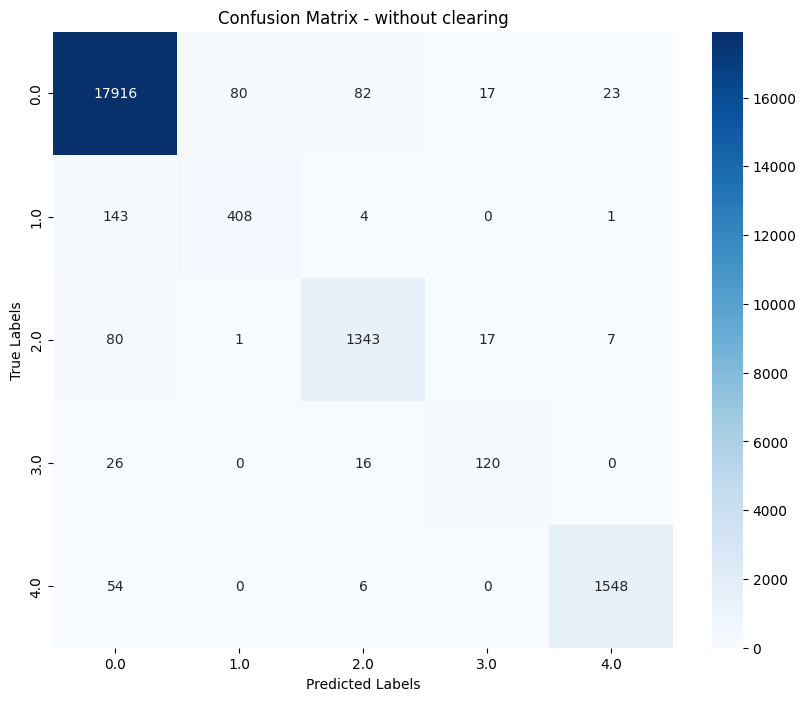

In [106]:
labels = np.unique(y_test_iqr)

conf_matrix = confusion_matrix(y_test_iqr, y_pred_test_iqr)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [107]:
y_test_iqr = label_binarize(y_test_iqr, classes=[0, 1, 2, 3, 4])

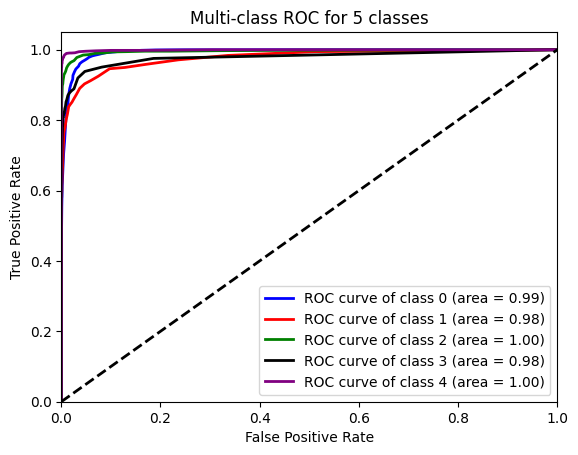

In [108]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_iqr])
    fpr[i], tpr[i], _ = roc_curve(y_test_iqr[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

wavelet

In [109]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized_wavelet, y_train_wavelet)

start = time.time()
y_pred_valid_wavelet = rf_classifier.predict(x_valid_normalized_wavelet)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_wavelet = accuracy_score(y_valid_wavelet, y_pred_valid_wavelet)
print("Validation Accuracy:", accuracy_valid_wavelet)

start = time.time()
y_pred_test_wavelet = rf_classifier.predict(x_test_normalized_wavelet)
finish = time.time()
y_score_wavelet = rf_classifier.predict_proba(x_test_normalized_wavelet)

print("Test predict time:", finish - start)
accuracy_test_wavelet = accuracy_score(y_test_wavelet, y_pred_test_wavelet)
print("Test Accuracy:", accuracy_test_wavelet)


print("\nClassification Report:")
print(classification_report(y_test_wavelet, y_pred_test_wavelet))

Validation predict time: 0.13654518127441406
Validation Accuracy: 0.99555
Test predict time: 0.11162757873535156
Test Accuracy: 0.9739174127535173

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.81      0.75      0.78       556
         2.0       0.92      0.93      0.93      1448
         3.0       0.77      0.74      0.75       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.89      0.88      0.88     21892
weighted avg       0.97      0.97      0.97     21892



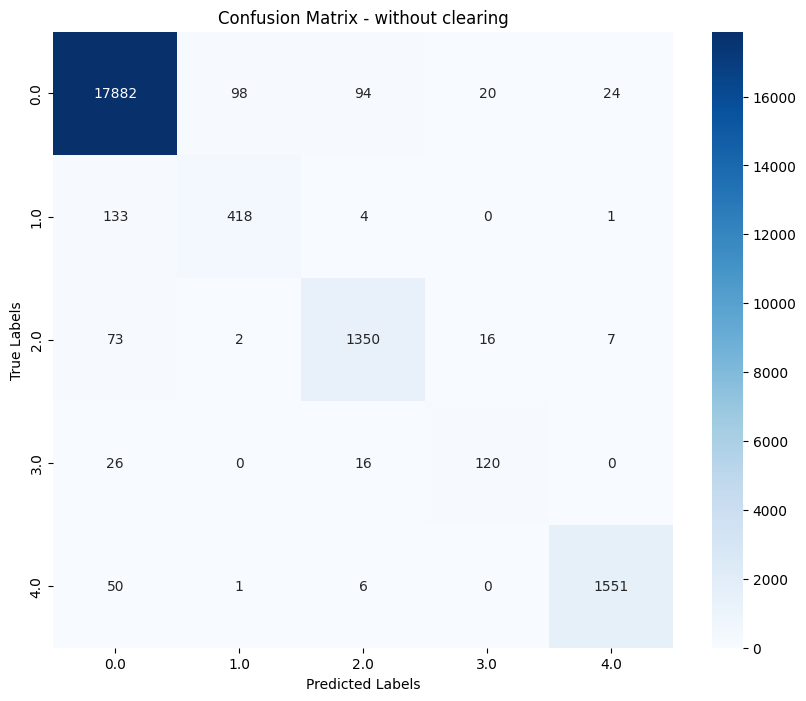

In [110]:
labels = np.unique(y_test_wavelet)

conf_matrix = confusion_matrix(y_test_wavelet, y_pred_test_wavelet)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [111]:
y_test_wavelet = label_binarize(y_test_wavelet, classes=[0, 1, 2, 3, 4])

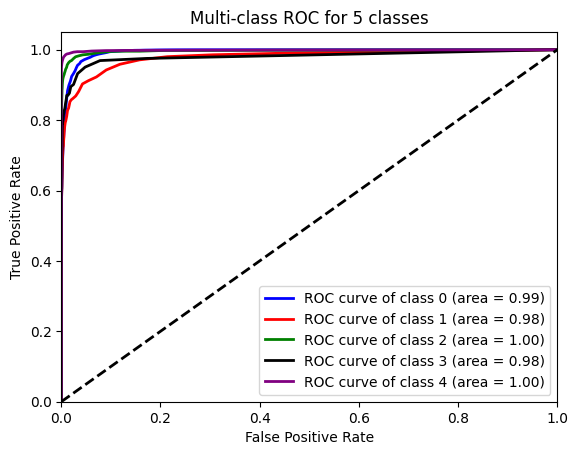

In [112]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_wavelet])
    fpr[i], tpr[i], _ = roc_curve(y_test_wavelet[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

maf

In [113]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized_maf, y_train_maf)

start = time.time()
y_pred_valid_maf = rf_classifier.predict(x_valid_normalized_maf)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_maf = accuracy_score(y_valid_maf, y_pred_valid_maf)
print("Validation Accuracy:", accuracy_valid_maf)

start = time.time()
y_pred_test_maf = rf_classifier.predict(x_test_normalized_maf)
finish = time.time()
y_score_maf = rf_classifier.predict_proba(x_test_normalized_maf)

print("Test predict time:", finish - start)
accuracy_test_maf = accuracy_score(y_test_maf, y_pred_test_maf)
print("Test Accuracy:", accuracy_test_maf)


print("\nClassification Report:")
print(classification_report(y_test_maf, y_pred_test_maf))

Validation predict time: 0.10676264762878418
Validation Accuracy: 0.99525
Test predict time: 0.11162781715393066
Test Accuracy: 0.972272976429746

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     18118
         1.0       0.84      0.70      0.76       556
         2.0       0.92      0.93      0.93      1448
         3.0       0.83      0.45      0.58       162
         4.0       0.98      0.95      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.91      0.80      0.85     21892
weighted avg       0.97      0.97      0.97     21892



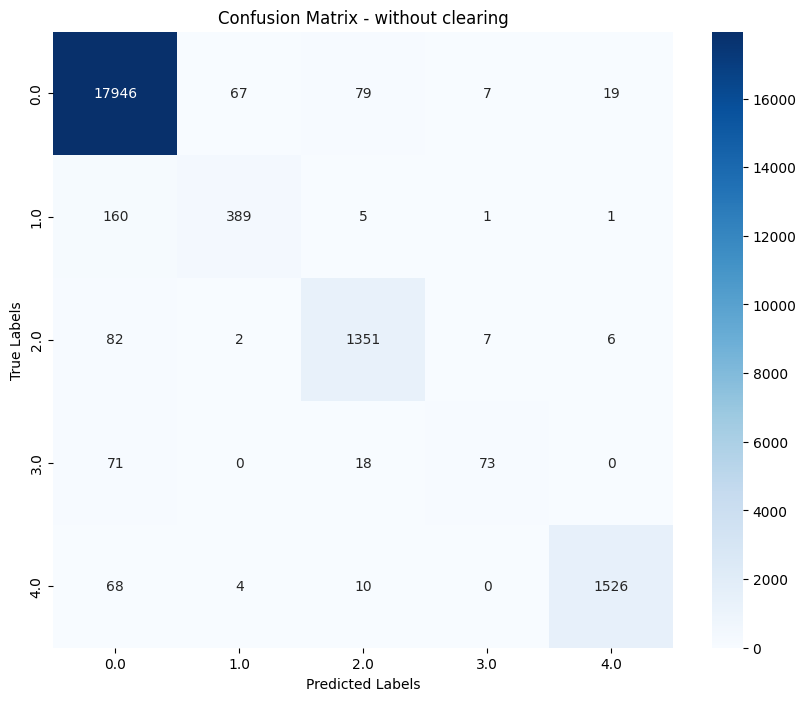

In [114]:
labels = np.unique(y_test_maf)

conf_matrix = confusion_matrix(y_test_maf, y_pred_test_maf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [115]:
y_test_maf = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

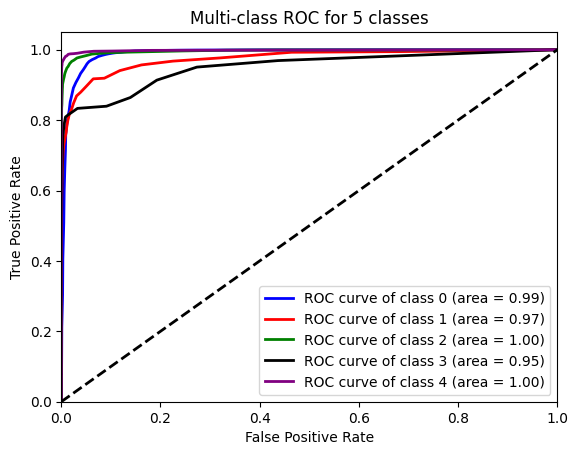

In [116]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_maf])
    fpr[i], tpr[i], _ = roc_curve(y_test_maf[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

mf

In [117]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized_mf, y_train_mf)

start = time.time()
y_pred_valid_mf = rf_classifier.predict(x_valid_normalized_mf)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_mf = accuracy_score(y_valid_mf, y_pred_valid_mf)
print("Validation Accuracy:", accuracy_valid_mf)

start = time.time()
y_pred_test_mf = rf_classifier.predict(x_test_normalized_mf)
finish = time.time()
y_score_mf = rf_classifier.predict_proba(x_test_normalized_mf)

print("Test predict time:", finish - start)
accuracy_test_mf = accuracy_score(y_test_mf, y_pred_test_mf)
print("Test Accuracy:", accuracy_test_mf)


print("\nClassification Report:")
print(classification_report(y_test_mf, y_pred_test_mf))

Validation predict time: 0.10863685607910156
Validation Accuracy: 0.996
Test predict time: 0.10365414619445801
Test Accuracy: 0.9747853097021744

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.99     18118
         1.0       0.84      0.74      0.78       556
         2.0       0.92      0.93      0.93      1448
         3.0       0.81      0.68      0.74       162
         4.0       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.91      0.86      0.88     21892
weighted avg       0.97      0.97      0.97     21892



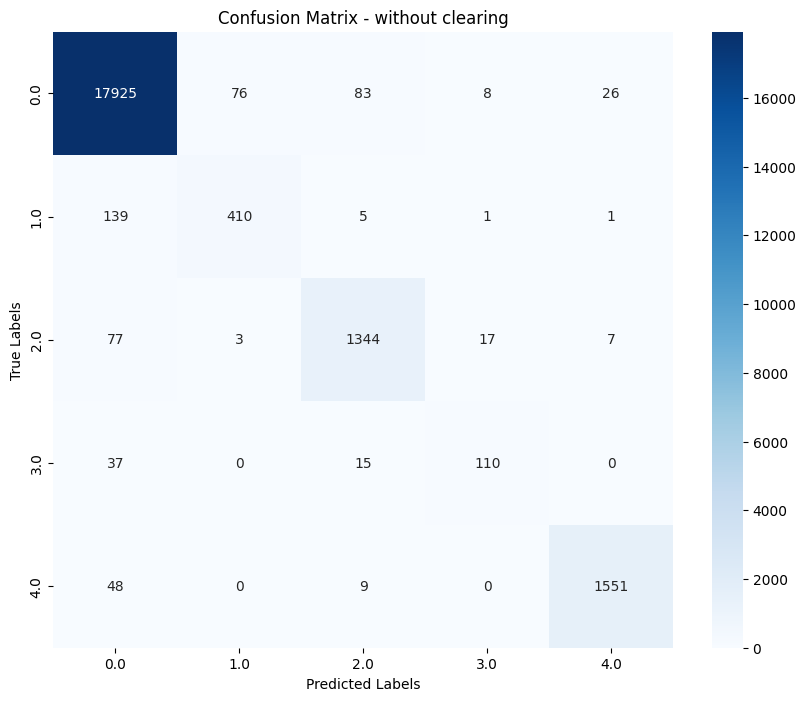

In [118]:
labels = np.unique(y_test_mf)

conf_matrix = confusion_matrix(y_test_mf, y_pred_test_mf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [119]:
y_test_mf = label_binarize(y_test_mf, classes=[0, 1, 2, 3, 4])

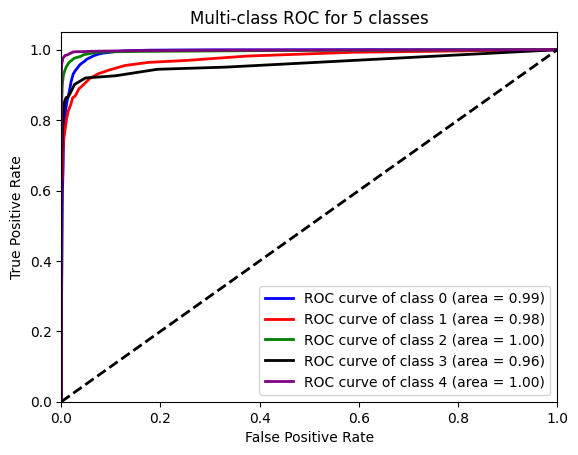

In [120]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_mf])
    fpr[i], tpr[i], _ = roc_curve(y_test_mf[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

wd

In [121]:
rf_classifier = RandomForestClassifier(n_estimators=50, random_state=123)

rf_classifier.fit(x_train_normalized_wd, y_train_wd)

start = time.time()
y_pred_valid_wd = rf_classifier.predict(x_valid_normalized_wd)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_wd = accuracy_score(y_valid_wd, y_pred_valid_wd)
print("Validation Accuracy:", accuracy_valid_wd)

start = time.time()
y_pred_test_wd = rf_classifier.predict(x_test_normalized_wd)
finish = time.time()
y_score_wd = rf_classifier.predict_proba(x_test_normalized_wd)

print("Test predict time:", finish - start)
accuracy_test_wd = accuracy_score(y_test_wd, y_pred_test_wd)
print("Test Accuracy:", accuracy_test_wd)


print("\nClassification Report:")
print(classification_report(y_test_wd, y_pred_test_wd))

Validation predict time: 0.12983179092407227
Validation Accuracy: 0.99535
Test predict time: 0.10265803337097168
Test Accuracy: 0.8163712771788781

Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.86      0.91     18118
         1.0       0.87      0.51      0.64       556
         2.0       0.29      0.96      0.45      1448
         3.0       0.79      0.59      0.67       162
         4.0       0.96      0.32      0.48      1608

    accuracy                           0.82     21892
   macro avg       0.78      0.65      0.63     21892
weighted avg       0.92      0.82      0.84     21892



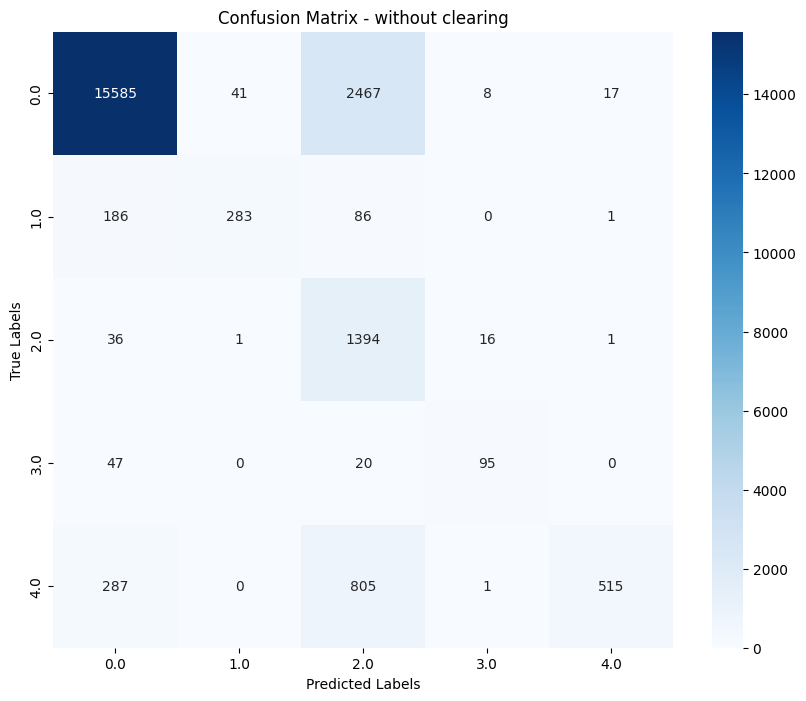

In [122]:
labels = np.unique(y_test_wd)

conf_matrix = confusion_matrix(y_test_wd, y_pred_test_wd)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [123]:
y_test_wd = label_binarize(y_test_wd, classes=[0, 1, 2, 3, 4])

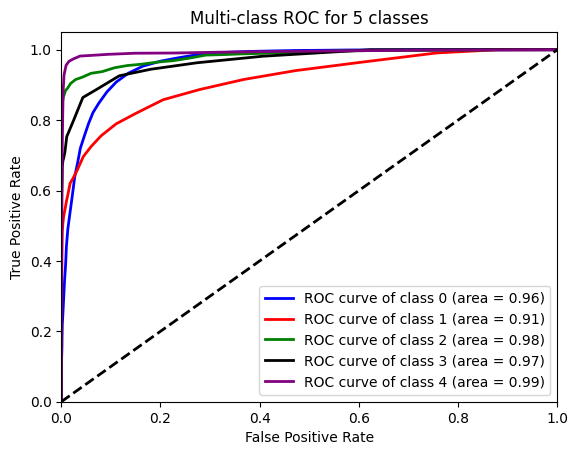

In [124]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_wd])
    fpr[i], tpr[i], _ = roc_curve(y_test_wd[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

**GBM**

without clearing

In [125]:
x_train = train_df.drop(columns = [187])
y_train = train_df[187]

In [126]:
x_train, x_valid, y_train, y_valid = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

x_test = test_df.drop(columns=[187])
y_test = test_df[187]

scaler = StandardScaler()

x_train_normalized = scaler.fit_transform(x_train)
x_valid_normalized = scaler.transform(x_valid)
x_test_normalized = scaler.transform(x_test)

3_sigma

In [127]:
x_train_3_sigma = train_df_cleaned_3_sigma.drop(columns = [187])
y_train_3_sigma = train_df_cleaned_3_sigma[187]

In [128]:
x_train_3_sigma, x_valid_3_sigma, y_train_3_sigma, y_valid_3_sigma = train_test_split(x_train_3_sigma, y_train_3_sigma, test_size=0.2, random_state=42)

x_test_3_sigma = test_df.drop(columns=[187])
y_test_3_sigma = test_df[187]

scaler = StandardScaler()

x_train_normalized_3_sigma = scaler.fit_transform(x_train_3_sigma)
x_valid_normalized_3_sigma = scaler.transform(x_valid_3_sigma)
x_test_normalized_3_sigma = scaler.transform(x_test_3_sigma)

IQR

In [129]:
x_train_iqr = train_df_cleaned_iqr.drop(columns = [187])
y_train_iqr = train_df_cleaned_iqr[187]

In [130]:
x_train_iqr, x_valid_iqr, y_train_iqr, y_valid_iqr = train_test_split(x_train_iqr, y_train_iqr, test_size=0.2, random_state=42)

x_test_iqr = test_df.drop(columns=[187])
y_test_iqr = test_df[187]

scaler = StandardScaler()

x_train_normalized_iqr = scaler.fit_transform(x_train_iqr)
x_valid_normalized_iqr = scaler.transform(x_valid_iqr)
x_test_normalized_iqr = scaler.transform(x_test_iqr)

wavelet

In [131]:
x_train_wavelet = train_df_cleaned_wavelet.drop(columns = [187])
y_train_wavelet = train_df_cleaned_wavelet[187]

In [132]:
x_train_wavelet, x_valid_wavelet, y_train_wavelet, y_valid_wavelet = train_test_split(x_train_wavelet, y_train_wavelet, test_size=0.2, random_state=42)

x_test_wavelet = test_df.drop(columns=[187])
y_test_wavelet = test_df[187]

scaler = StandardScaler()

x_train_normalized_wavelet = scaler.fit_transform(x_train_wavelet)
x_valid_normalized_wavelet = scaler.transform(x_valid_wavelet)
x_test_normalized_wavelet = scaler.transform(x_test_wavelet)

MAF

In [133]:
x_train_maf = train_df_filtered_maf.drop(columns = [187])
y_train_maf = train_df_filtered_maf[187]

In [134]:
x_train_maf, x_valid_maf, y_train_maf, y_valid_maf = train_test_split(x_train_maf, y_train_maf, test_size=0.2, random_state=42)

x_test_maf = test_df.drop(columns=[187])
y_test_maf = test_df[187]

scaler = StandardScaler()

x_train_normalized_maf = scaler.fit_transform(x_train_maf)
x_valid_normalized_maf = scaler.transform(x_valid_maf)
x_test_normalized_maf = scaler.transform(x_test_maf)

MF

In [135]:
x_train_mf = train_df_filtered_mf.drop(columns = [187])
y_train_mf = train_df_filtered_mf[187]

In [136]:
x_train_mf, x_valid_mf, y_train_mf, y_valid_mf = train_test_split(x_train_mf, y_train_mf, test_size=0.2, random_state=42)

x_test_mf = test_df.drop(columns=[187])
y_test_mf = test_df[187]

scaler = StandardScaler()

x_train_normalized_mf = scaler.fit_transform(x_train_mf)
x_valid_normalized_mf = scaler.transform(x_valid_mf)
x_test_normalized_mf = scaler.transform(x_test_mf)

WD

In [137]:
x_train_wd = train_df_filtered_wd.drop(columns = [187])
y_train_wd = train_df_filtered_wd[187]

In [138]:
x_train_wd, x_valid_wd, y_train_wd, y_valid_wd = train_test_split(x_train_wd, y_train_wd, test_size=0.2, random_state=42)

x_test_wd = test_df.drop(columns=[187])
y_test_wd = test_df[187]

scaler = StandardScaler()

x_train_normalized_wd = scaler.fit_transform(x_train_wd)
x_valid_normalized_wd = scaler.transform(x_valid_wd)
x_test_normalized_wd = scaler.transform(x_test_wd)

without clearing

In [139]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized, y_train)


start = time.time()
y_pred_valid = gbm_classifier.predict(x_valid_normalized)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid = accuracy_score(y_valid, y_pred_valid)
print("Validation Accuracy:", accuracy_valid)


start = time.time()
y_pred_test = gbm_classifier.predict(x_test_normalized)
finish = time.time()
y_score = gbm_classifier.predict_proba(x_test_normalized)

print("Test predict time:", finish - start)
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)


print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

Validation predict time: 0.07275748252868652
Validation Accuracy: 0.8937
Test predict time: 0.07674360275268555
Test Accuracy: 0.8458797734332176

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.84      0.90     18118
         1.0       0.29      0.76      0.42       556
         2.0       0.61      0.88      0.72      1448
         3.0       0.13      0.90      0.22       162
         4.0       0.83      0.95      0.89      1608

    accuracy                           0.85     21892
   macro avg       0.57      0.86      0.63     21892
weighted avg       0.93      0.85      0.87     21892



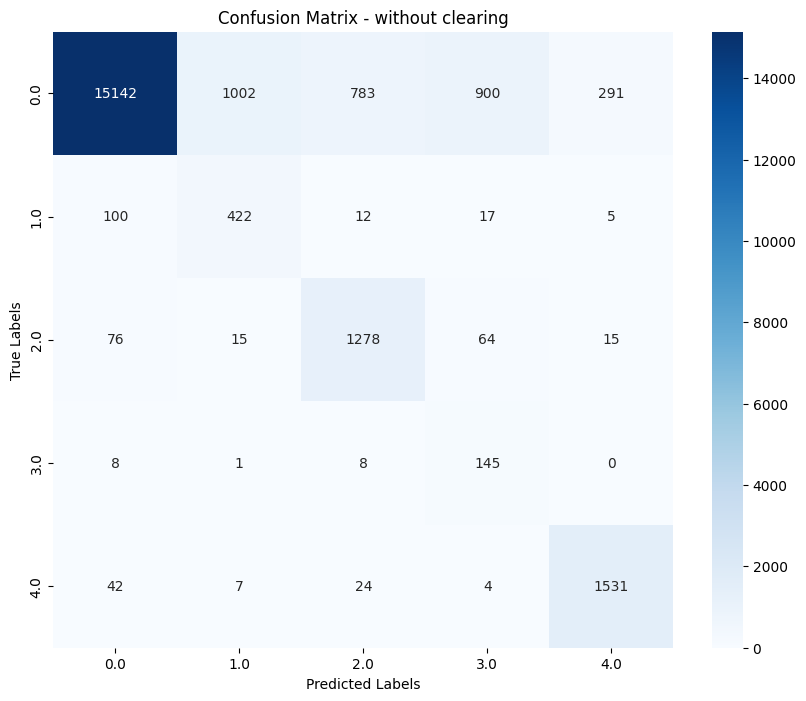

In [140]:
labels = np.unique(y_test)

conf_matrix = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [141]:
y_test = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

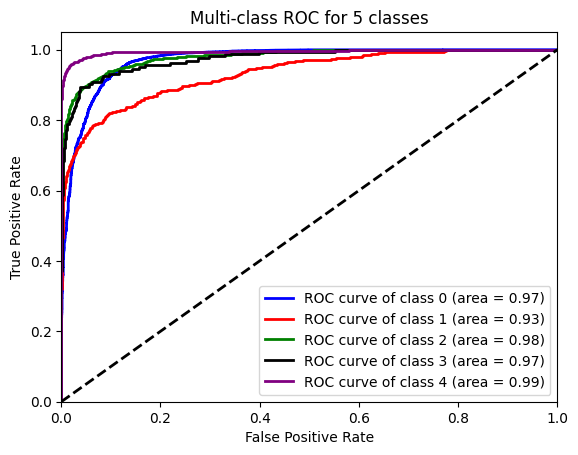

In [142]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score])
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

3-sigma

In [143]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized_3_sigma, y_train_3_sigma)


start = time.time()
y_pred_valid_3_sigma = gbm_classifier.predict(x_valid_normalized_3_sigma)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_3_sigma = accuracy_score(y_valid_3_sigma, y_pred_valid_3_sigma)
print("Validation Accuracy:", accuracy_valid)


start = time.time()
y_pred_test_3_sigma = gbm_classifier.predict(x_test_normalized_3_sigma)
finish = time.time()
y_score_3_sigma = gbm_classifier.predict_proba(x_test_normalized_3_sigma)

print("Test predict time:", finish - start)
accuracy_test_3_sigma = accuracy_score(y_test_3_sigma, y_pred_test_3_sigma)
print("Test Accuracy:", accuracy_test_3_sigma)


print("\nClassification Report:")
print(classification_report(y_test_3_sigma, y_pred_test_3_sigma))

Validation predict time: 0.07275772094726562
Validation Accuracy: 0.8937
Test predict time: 0.07973408699035645
Test Accuracy: 0.8387538826968756

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     18118
         1.0       0.29      0.76      0.42       556
         2.0       0.64      0.88      0.74      1448
         3.0       0.10      0.90      0.19       162
         4.0       0.83      0.95      0.89      1608

    accuracy                           0.84     21892
   macro avg       0.57      0.86      0.63     21892
weighted avg       0.93      0.84      0.87     21892



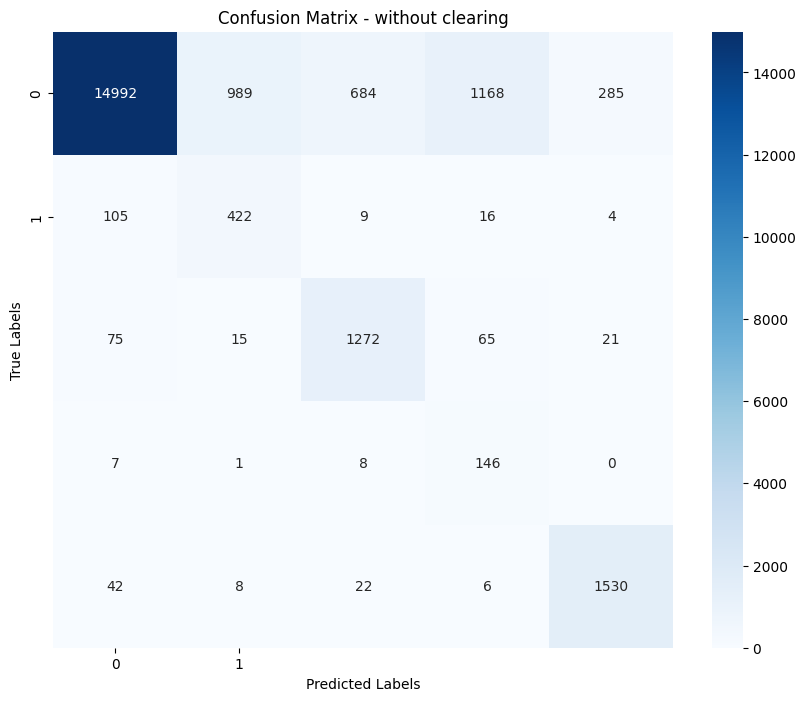

In [144]:
labels = np.unique(y_test)

conf_matrix = confusion_matrix(y_test_3_sigma, y_pred_test_3_sigma)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [145]:
y_test_3_sigma = label_binarize(y_test_3_sigma, classes=[0, 1, 2, 3, 4])

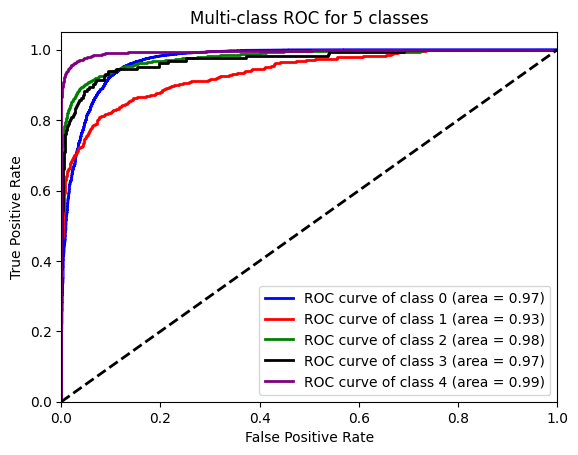

In [146]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_3_sigma])
    fpr[i], tpr[i], _ = roc_curve(y_test_3_sigma[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

IQR

In [147]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized_iqr, y_train_iqr)


start = time.time()
y_pred_valid_iqr = gbm_classifier.predict(x_valid_normalized_iqr)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_iqr = accuracy_score(y_valid_iqr, y_pred_valid_iqr)
print("Validation Accuracy:", accuracy_valid_iqr)


start = time.time()
y_pred_test_iqr = gbm_classifier.predict(x_test_normalized_iqr)
finish = time.time()
y_score_iqr = gbm_classifier.predict_proba(x_test_normalized_iqr)

print("Test predict time:", finish - start)
accuracy_test_iqr = accuracy_score(y_test_iqr, y_pred_test_iqr)
print("Test Accuracy:", accuracy_test_iqr)


print("\nClassification Report:")
print(classification_report(y_test_iqr, y_pred_test_iqr))

Validation predict time: 0.07176089286804199
Validation Accuracy: 0.89035
Test predict time: 0.07973432540893555
Test Accuracy: 0.8407637493148182

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.83      0.90     18118
         1.0       0.26      0.76      0.38       556
         2.0       0.63      0.85      0.72      1448
         3.0       0.13      0.89      0.22       162
         4.0       0.84      0.95      0.89      1608

    accuracy                           0.84     21892
   macro avg       0.57      0.86      0.62     21892
weighted avg       0.92      0.84      0.87     21892



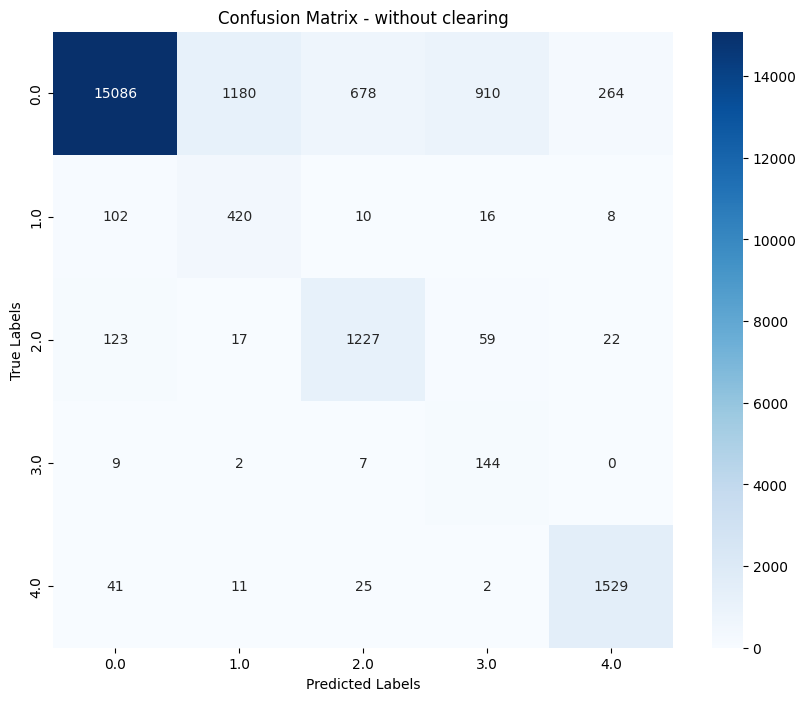

In [148]:
labels = np.unique(y_test_iqr)

conf_matrix = confusion_matrix(y_test_iqr, y_pred_test_iqr)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [149]:
y_test_iqr = label_binarize(y_test_iqr, classes=[0, 1, 2, 3, 4])

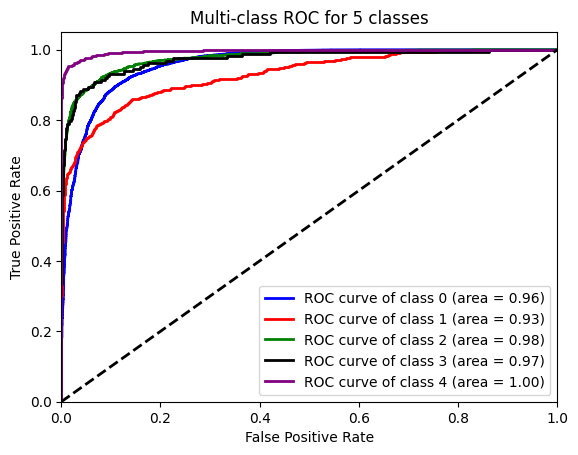

In [150]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_iqr])
    fpr[i], tpr[i], _ = roc_curve(y_test_iqr[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

wavelet

In [151]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized_wavelet, y_train_wavelet)


start = time.time()
y_pred_valid_wavelet = gbm_classifier.predict(x_valid_normalized_wavelet)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_wavelet = accuracy_score(y_valid_wavelet, y_pred_valid_wavelet)
print("Validation Accuracy:", accuracy_valid_wavelet)


start = time.time()
y_pred_test_wavelet = gbm_classifier.predict(x_test_normalized_wavelet)
finish = time.time()
y_score_wavelet = gbm_classifier.predict_proba(x_test_normalized_wavelet)

print("Test predict time:", finish - start)
accuracy_test_wavelet = accuracy_score(y_test_wavelet, y_pred_test_wavelet)
print("Test Accuracy:", accuracy_test_wavelet)


print("\nClassification Report:")
print(classification_report(y_test_wavelet, y_pred_test_wavelet))

Validation predict time: 0.07246875762939453
Validation Accuracy: 0.89405
Test predict time: 0.07772660255432129
Test Accuracy: 0.8446464461903892

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.83      0.90     18118
         1.0       0.29      0.76      0.42       556
         2.0       0.60      0.89      0.72      1448
         3.0       0.13      0.90      0.22       162
         4.0       0.83      0.95      0.89      1608

    accuracy                           0.84     21892
   macro avg       0.57      0.87      0.63     21892
weighted avg       0.93      0.84      0.87     21892



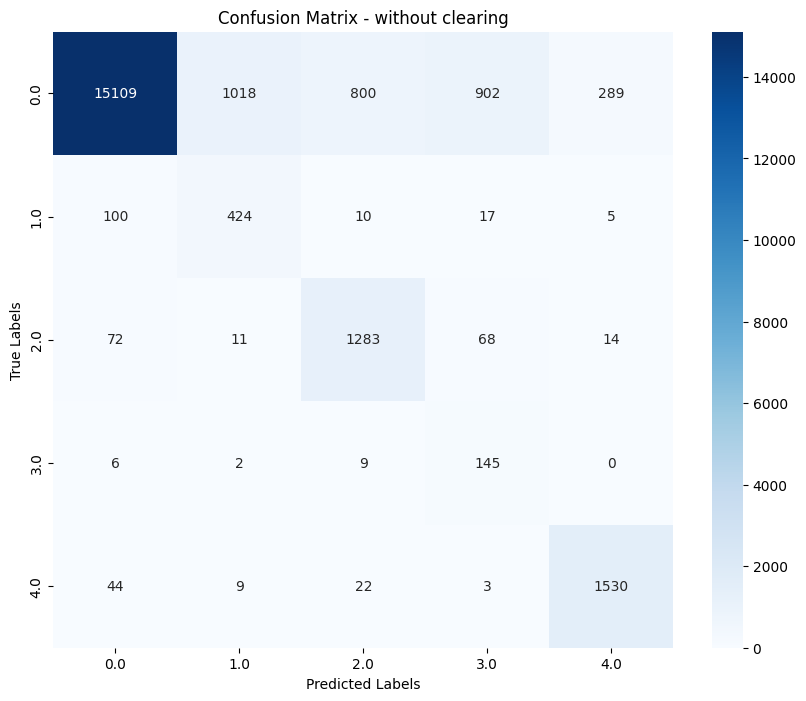

In [152]:
labels = np.unique(y_test_wavelet)

conf_matrix = confusion_matrix(y_test_wavelet, y_pred_test_wavelet)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [153]:
y_test_wavelet = label_binarize(y_test_wavelet, classes=[0, 1, 2, 3, 4])

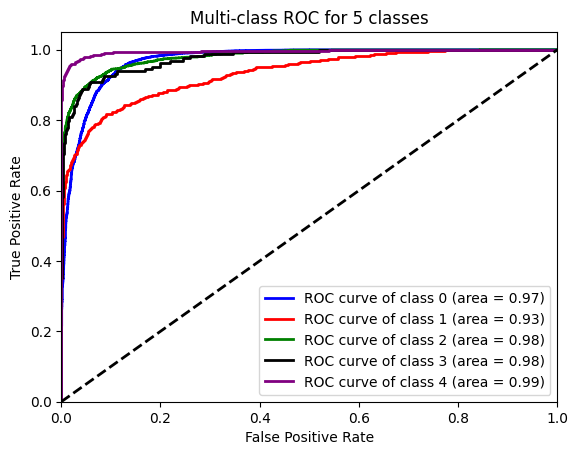

In [154]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_wavelet])
    fpr[i], tpr[i], _ = roc_curve(y_test_wavelet[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

maf

In [155]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized_maf, y_train_maf)


start = time.time()
y_pred_valid_maf = gbm_classifier.predict(x_valid_normalized_maf)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_maf = accuracy_score(y_valid_maf, y_pred_valid_maf)
print("Validation Accuracy:", accuracy_valid_maf)


start = time.time()
y_pred_test_maf = gbm_classifier.predict(x_test_normalized_maf)
finish = time.time()
y_score_maf = gbm_classifier.predict_proba(x_test_normalized_maf)

print("Test predict time:", finish - start)
accuracy_test_maf = accuracy_score(y_test_maf, y_pred_test_maf)
print("Test Accuracy:", accuracy_test_maf)


print("\nClassification Report:")
print(classification_report(y_test_maf, y_pred_test_maf))

Validation predict time: 0.07873773574829102
Validation Accuracy: 0.88815
Test predict time: 0.07873749732971191
Test Accuracy: 0.748264206102686

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.72      0.83     18118
         1.0       0.13      0.77      0.22       556
         2.0       0.47      0.85      0.61      1448
         3.0       0.16      0.86      0.27       162
         4.0       0.90      0.90      0.90      1608

    accuracy                           0.75     21892
   macro avg       0.53      0.82      0.57     21892
weighted avg       0.91      0.75      0.80     21892



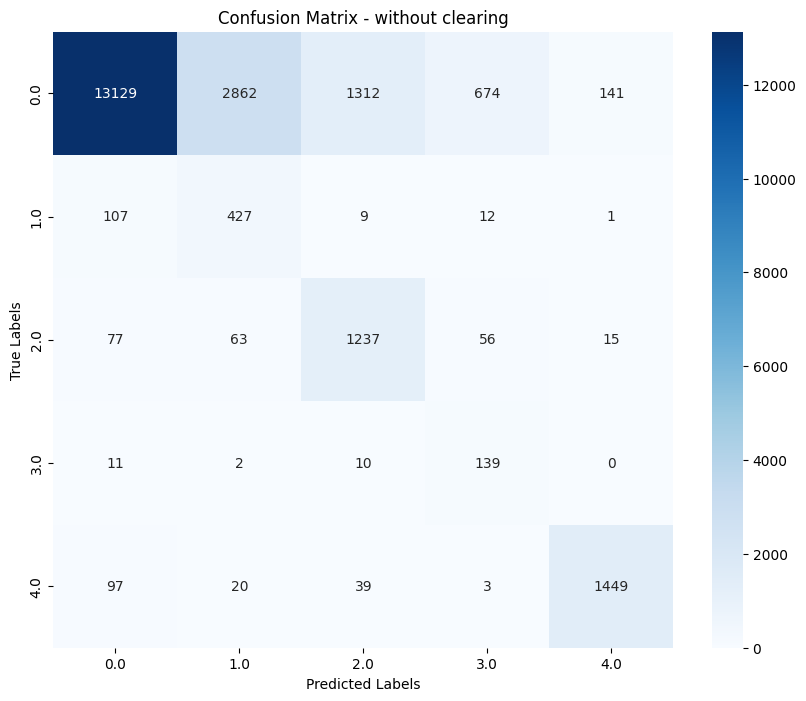

In [156]:
labels = np.unique(y_test_maf)

conf_matrix = confusion_matrix(y_test_maf, y_pred_test_maf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [157]:
y_test_maf = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

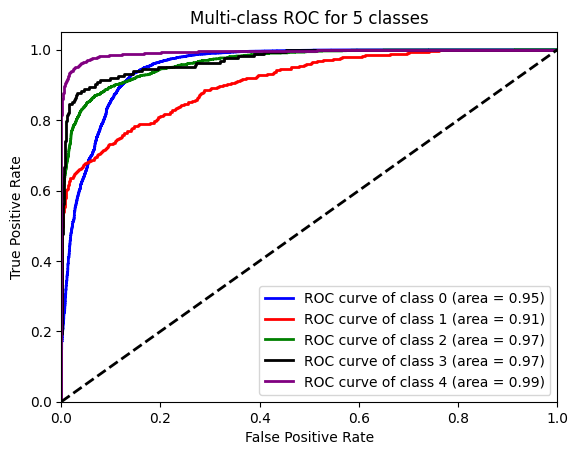

In [158]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_maf])
    fpr[i], tpr[i], _ = roc_curve(y_test_maf[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

mf

In [159]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized_mf, y_train_mf)


start = time.time()
y_pred_valid_mf = gbm_classifier.predict(x_valid_normalized_mf)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_mf = accuracy_score(y_valid_mf, y_pred_valid_mf)
print("Validation Accuracy:", accuracy_valid_mf)


start = time.time()
y_pred_test_mf = gbm_classifier.predict(x_test_normalized_mf)
finish = time.time()
y_score_mf = gbm_classifier.predict_proba(x_test_normalized_mf)

print("Test predict time:", finish - start)
accuracy_test_mf = accuracy_score(y_test_mf, y_pred_test_mf)
print("Test Accuracy:", accuracy_test_mf)


print("\nClassification Report:")
print(classification_report(y_test_mf, y_pred_test_mf))

Validation predict time: 0.08073115348815918
Validation Accuracy: 0.88855
Test predict time: 0.09169602394104004
Test Accuracy: 0.7848072355198246

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.76      0.86     18118
         1.0       0.16      0.80      0.27       556
         2.0       0.59      0.88      0.70      1448
         3.0       0.12      0.89      0.21       162
         4.0       0.85      0.95      0.90      1608

    accuracy                           0.78     21892
   macro avg       0.54      0.85      0.59     21892
weighted avg       0.92      0.78      0.83     21892



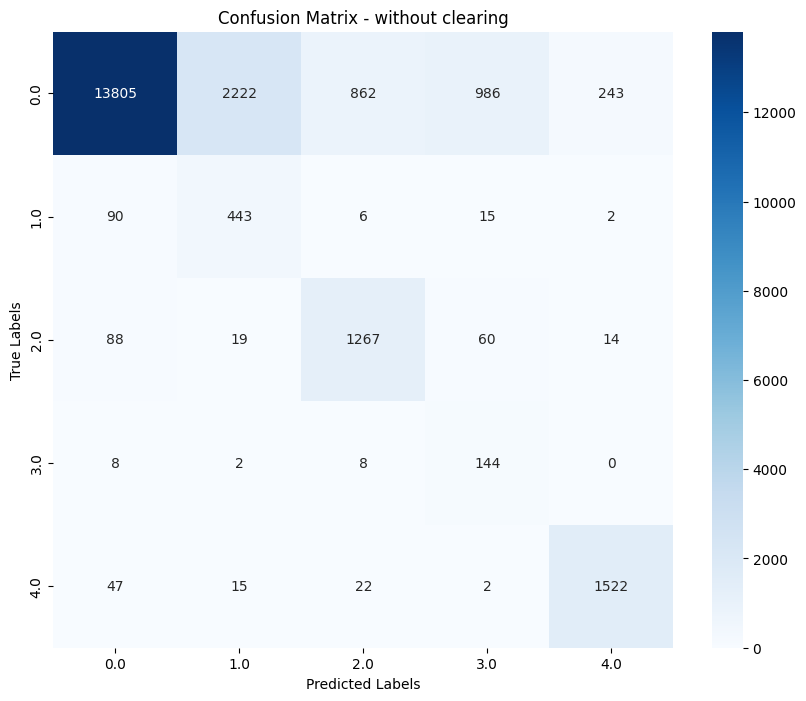

In [160]:
labels = np.unique(y_test_mf)

conf_matrix = confusion_matrix(y_test_mf, y_pred_test_mf)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [161]:
y_test_mf = label_binarize(y_test_mf, classes=[0, 1, 2, 3, 4])

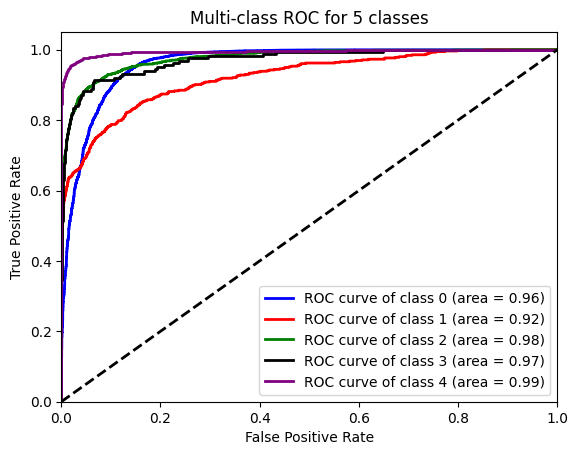

In [162]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_mf])
    fpr[i], tpr[i], _ = roc_curve(y_test_mf[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()

wd

In [163]:
from sklearn.ensemble import GradientBoostingClassifier

gbm_classifier = GradientBoostingClassifier(n_estimators=50, random_state=123)

gbm_classifier.fit(x_train_normalized_wd, y_train_wd)


start = time.time()
y_pred_valid_wd = gbm_classifier.predict(x_valid_normalized_wd)
finish = time.time()

print("Validation predict time:", finish - start)
accuracy_valid_wd = accuracy_score(y_valid_wd, y_pred_valid_wd)
print("Validation Accuracy:", accuracy_valid_wd)


start = time.time()
y_pred_test_wd = gbm_classifier.predict(x_test_normalized_wd)
finish = time.time()
y_score_wd = gbm_classifier.predict_proba(x_test_normalized_wd)

print("Test predict time:", finish - start)
accuracy_test_wd = accuracy_score(y_test_wd, y_pred_test_wd)
print("Test Accuracy:", accuracy_test_wd)


print("\nClassification Report:")
print(classification_report(y_test_wd, y_pred_test_wd))

Validation predict time: 0.08172750473022461
Validation Accuracy: 0.89425
Test predict time: 0.08172750473022461
Test Accuracy: 0.7184359583409464

Classification Report:
              precision    recall  f1-score   support

         0.0       0.99      0.69      0.81     18118
         1.0       0.40      0.66      0.50       556
         2.0       0.27      0.92      0.42      1448
         3.0       0.08      0.91      0.14       162
         4.0       0.94      0.90      0.92      1608

    accuracy                           0.72     21892
   macro avg       0.54      0.82      0.56     21892
weighted avg       0.91      0.72      0.78     21892



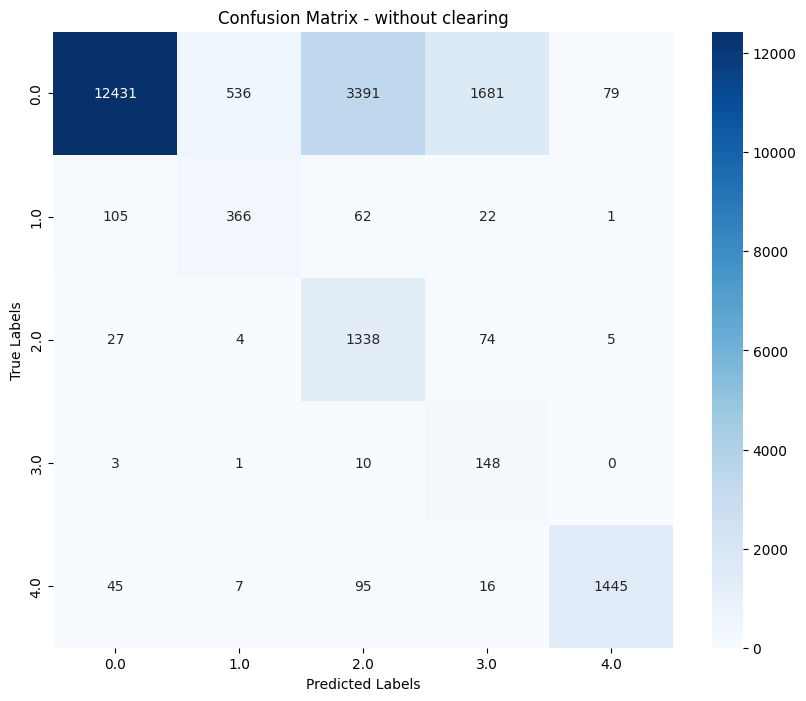

In [164]:
labels = np.unique(y_test_wd)

conf_matrix = confusion_matrix(y_test_wd, y_pred_test_wd)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - without clearing')
plt.show()

In [165]:
y_test_wd = label_binarize(y_test_wd, classes=[0, 1, 2, 3, 4])

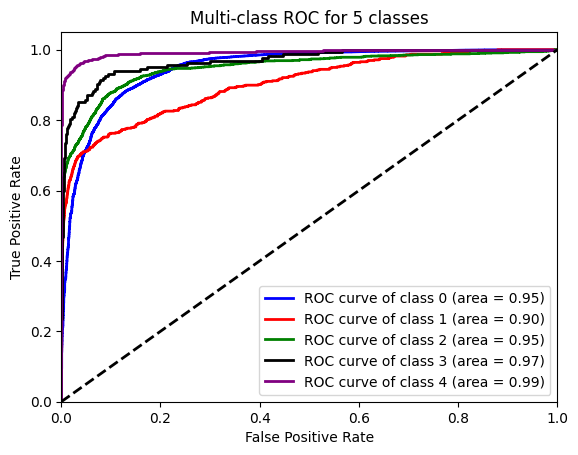

In [166]:
fpr = dict()
tpr = dict()
roc_auc = dict()


for i in range(5):
    y_score_class_i = np.array([score[i] for score in y_score_wd])
    fpr[i], tpr[i], _ = roc_curve(y_test_wd[:, i], y_score_class_i)
    roc_auc[i] = auc(fpr[i], tpr[i])




colors = ['blue', 'red', 'green', 'black', 'purple']
for i, color in zip(range(5), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC for 5 classes')
plt.legend(loc="lower right")
plt.show()